# Stroke Risk: A Machine Learning Approach 
#### The John Hopkins Hospital -- Baltimore, MD
***
## Overarching Aim
Our goal is to develop and deploy a predictive model that is capable of providing information about whether a patient is likely to incur a stroke (i.e. to determine which patients have high stroke risk). Ideally, the insights from this tool will prepare families in case of emergency, improve the diagnostic ability of our doctors, and maximize our capacity for preventative care. 

## Technical Objectives
- import data
- perform exploratory data analysis 
- perform statistical inference 
- data visualization
- develop a variety of machine learning models
- assess the quality of these models
- gain insights about meaningful features that relate to stroke likelihood
- deploy the machine learning model via a Flask application

import libraries & packages

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xgboost as xgb
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.exceptions import (
    ConvergenceWarning,
    FitFailedWarning,
    UndefinedMetricWarning,
)
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from utils.plots import (
    bar_plots_categorical_features,
    plot_confusion_matrix,
    plot_heatmap_contingency,
    plot_numeric_feature_histograms,
    plot_permutation_feature_importance,
    plot_proportional_distribution,
    plot_regressions,
    plot_roc_pr_curves_with_best_threshold,
    plot_stroke_class_frequency_by_bmi,
)
from utils.stats_ML import (
    bootstrap_confidence_interval_two_means,
    mean_diff_permutation,
    model_assessment_series,
    model_assessment_series_cv,
)

I only run the following cell for presentation purposes, otherwise I use these warnings to choose the optimal model. 

In [2]:
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import and inspect data

_note: Make sure healthcare-dataset-stroke-data.csv is available on the current path by modifying the variable named data_path_

In [ ]:
os.makedirs('data', exist_ok=True)
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset -p ./data --unzip

In [3]:
data_path = "./data/healthcare-dataset-stroke-data.csv"
stroke_df = pd.read_csv(data_path)
stroke_df = stroke_df.drop("id", axis=1)
stroke_df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


***
## Exploratory Data Analysis 

What are the data types?<br>&<br> Are there any missing data?

In [4]:
print(stroke_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB
None


In [5]:
pd.DataFrame(stroke_df.isnull().sum(), columns=["null values"])

,null values
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0


What do I notice? 
- there are 11 columns (10 predictors, 1 feature to predict)
- BMI is missing data (201 rows with null values) 
- the other columns do not contain null values
- the data types could be made more specific 

Transform Data Types

In [6]:
categorical_columns = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "stroke",
]
numerical_columns = ["age", "avg_glucose_level", "bmi"]
stroke_df[categorical_columns] = stroke_df[categorical_columns].astype("category")
stroke_df[numerical_columns] = stroke_df[numerical_columns].astype("float64")
stroke_df.dtypes

gender               category
age                   float64
hypertension         category
heart_disease        category
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke               category
dtype: object

### Categorical Data

In [7]:
stroke_df_cat = stroke_df[categorical_columns]
stroke_df_cat.describe()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
count,5110,5110,5110,5110,5110,5110,5110,5110
unique,3,2,2,2,5,2,4,2
top,Female,0,0,Yes,Private,Urban,never smoked,0
freq,2994,4612,4834,3353,2925,2596,1892,4861


- there are 5 binary categories and 3 multicategories
- gender does not appear to be a binary category

In [8]:
stroke_df["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

_note:<br>
there is only 1 entry that is not specifically male, nor female. <br>
While I would rather not lose data, it seems like the most reasonable approach for me is to drop this row. <br>
Although I could just as easily impute with the majority class (i.e. female), I would not want to unwillfully ignore nor misrepresent non-binary or otherwise identifying individuals._

In [9]:
indexOther = stroke_df[stroke_df["gender"] == "Other"].index
stroke_df = stroke_df.drop(indexOther)
stroke_df["gender"] = stroke_df["gender"].cat.remove_unused_categories()
stroke_df["gender"].unique()

['Male', 'Female']
Categories (2, object): ['Female', 'Male']

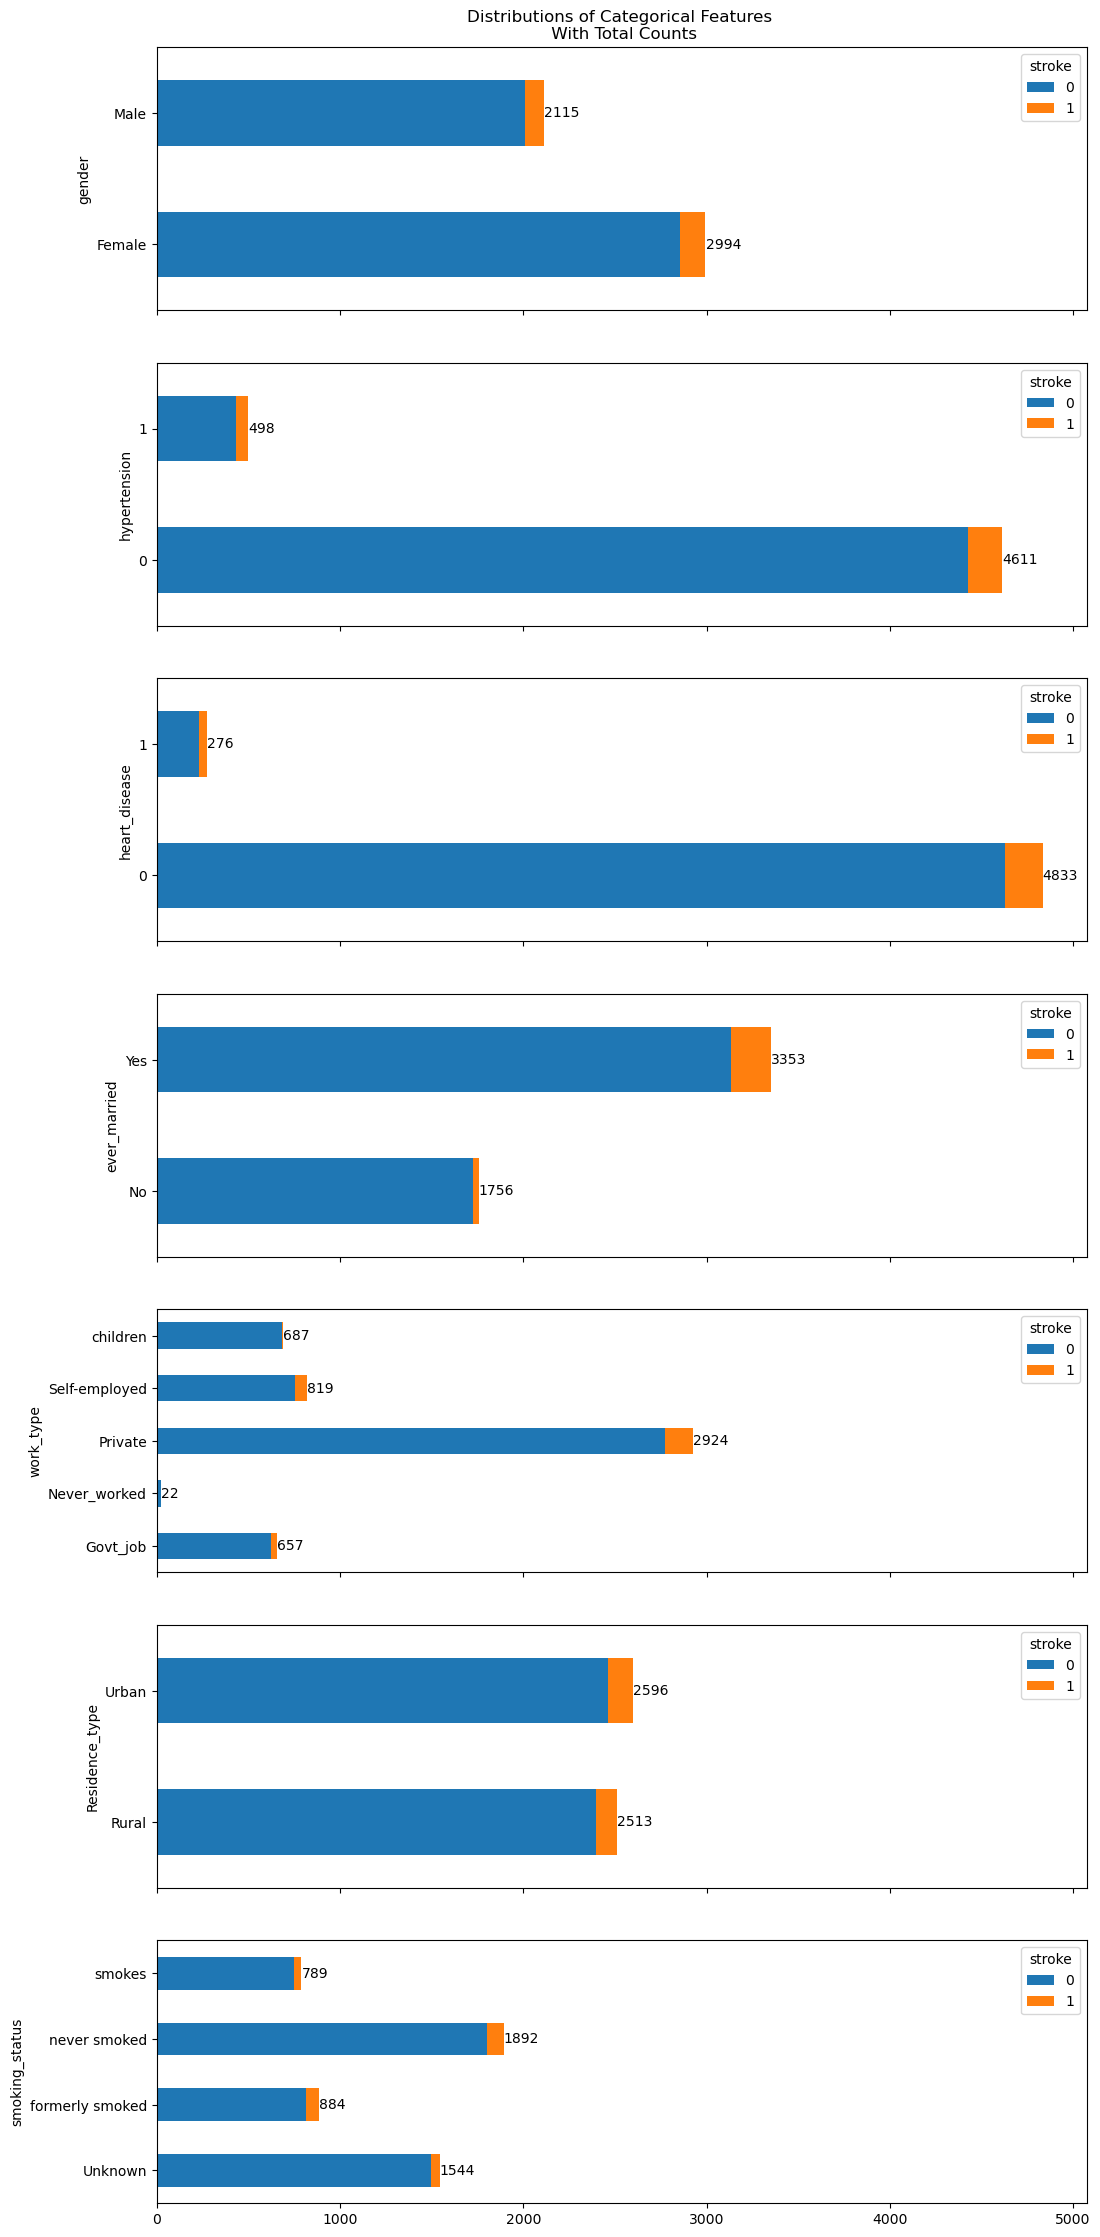

In [10]:
bar_plots_categorical_features(stroke_df, categorical_columns, "stroke")

Interim Summary of Categorical Data:<br>
- More females than males in the current dataset 
- Hypertension and heart disease are imbalanced classes, based on knowledge these are likely important classes for understanding stroke risk, but given the small sample size and relative amount of people in each class it might make sense to perform weighting/resampling when developing models. 
- There are more married than not married people in this sample. Again, weighting will be important. 
- Work type is an interesting category that is somewhat balanced, but contains distinct minority class of never-worked, and distinct majority of private employment. 
- Urban and rural is the most balanced class
- Smoking Status has a lot of unknown and never smoked. Unknown is not likely to be particularly useful for explanations of the data and could create predictive models that are not generalizable outside of training environment.

__Statistical analysis: Do more men or women have strokes?__

Approach: perform a Chi-squared analysis to assess whether the differences in what we observe versus what we expect are significantly different.<br><br>
_note: the assumptions of Chi-squared do not necessarily say that there are MORE of a specific gender that have strokes. Rather, the test asks if we observe a distribution that is significantly DIFFERENT than an expected null distribution of counts, given our data. In our data, we observe that slightly more females have strokes proportionally_

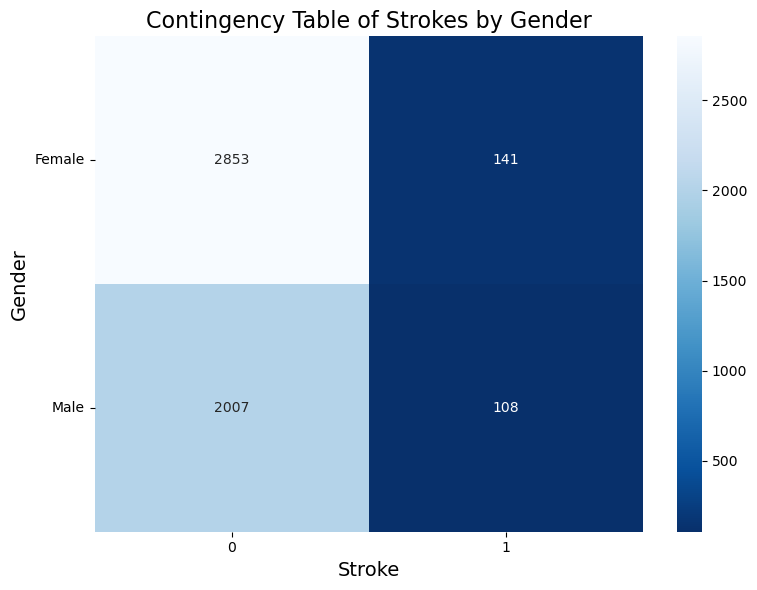

In [11]:
gender_stroke_contingency = plot_heatmap_contingency(
    stroke_df, "gender", "stroke", "Contingency Table of Strokes by Gender"
)

In [12]:
chi_2, p, _, expected = stats.chi2_contingency(gender_stroke_contingency)
print(
    f"Chi-Squared Statistic: {chi_2}, p-value: {p}.\nExpected distribution of counts: \n {expected}"
)

Chi-Squared Statistic: 0.340002536046177, p-value: 0.5598277580669416.
Expected distribution of counts: 
 [[2848.07985907  145.92014093]
 [2011.92014093  103.07985907]]


Given the current data, there is no indication of significant differences in the number of strokes observed between genders. 

### Numerical Data

In [13]:
stroke_df_num = stroke_df[numerical_columns]
stroke_df_num.describe()

,age,avg_glucose_level,bmi
count,5109.000000,5109.000000,4908.00000
mean,43.229986,106.140399,28.89456
std,22.613575,45.285004,7.85432
min,0.080000,55.120000,10.30000
25%,25.000000,77.240000,23.50000
50%,45.000000,91.880000,28.10000
75%,61.000000,114.090000,33.10000
max,82.000000,271.740000,97.60000


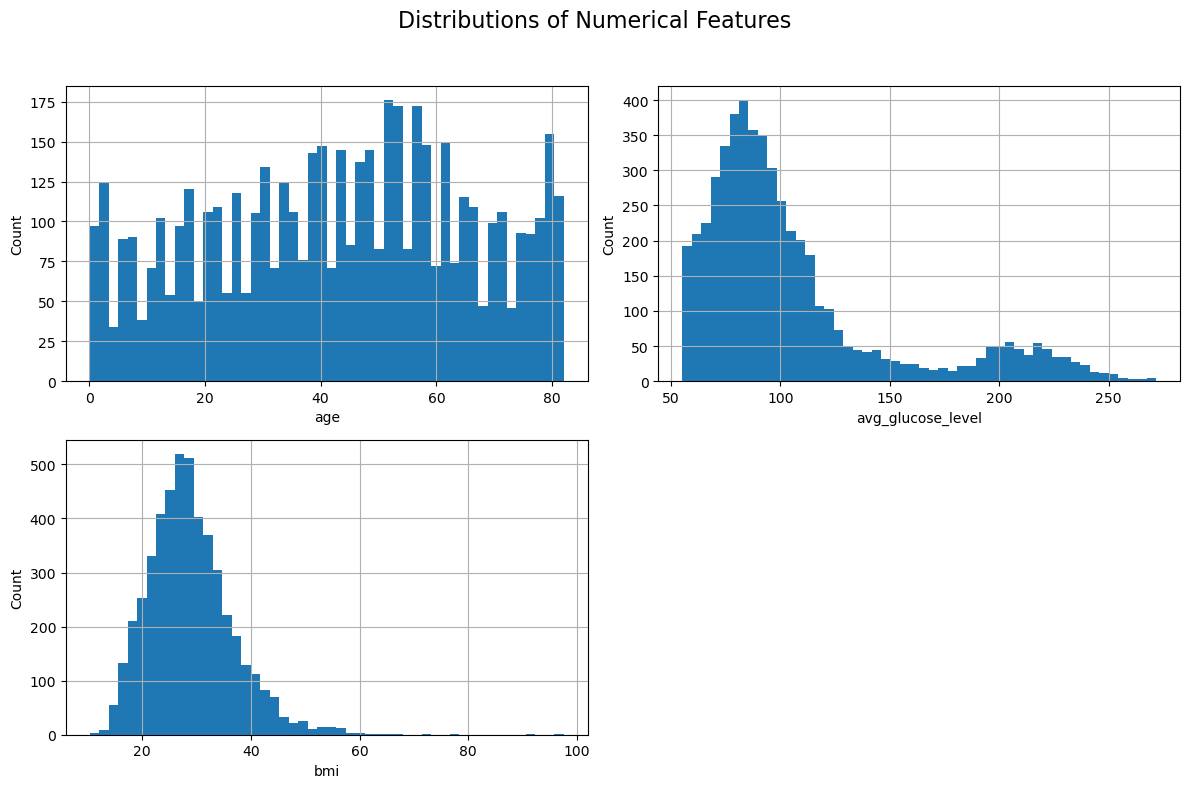

In [14]:
plot_numeric_feature_histograms(stroke_df)

interim summary of univariate sampling distributions:
- age is distributed across a wide range
- glucose level appears to have a long tail with a second bump (slightly bimodal distribution) 
- BMI has a long tail 

this leads me to ask:<br>
_What is the typical human range for BMI average glucose level and BMI?_ <br><br>

I am uncertain what units they are measuring blood glucose level in and would have to ask a domain expert. However, assuming they are using the American Diabetes Association (ADA) standard of mg/dL then this is a sensible range of values. (see this [paper](https://diabetesjournals.org/care/article/29/suppl_1/s4/23327/Standards-of-Medical-Care-in-Diabetes-2006) and this [website](www.diabetes.org))<br><br>
According to [this paper](https://www.psychiatriapolska.pl/Mortality-in-extremely-low-BMI-anorexia-nervosa-patients-implications-of-gastrointestinal,126233,0,2.html) the lowest ever recorded BMI is 6.7 and one of the highest ever recorded according to [Wikipedia](https://en.wikipedia.org/wiki/Jon_Brower_Minnoch) is 186. A typical range is ~10 in the case of anorexia up to ~40 in the case of extreme obesity based on the article and Wikipedia mentioned above. <br><br>
For this reason, I will drop any BMI value greater than 70 because this is likely due to measurement error as it may be too rare to exist in the frequency observed. 

In [15]:
stroke_df = stroke_df.drop(labels=stroke_df[stroke_df["bmi"] > 70].index, axis=0)

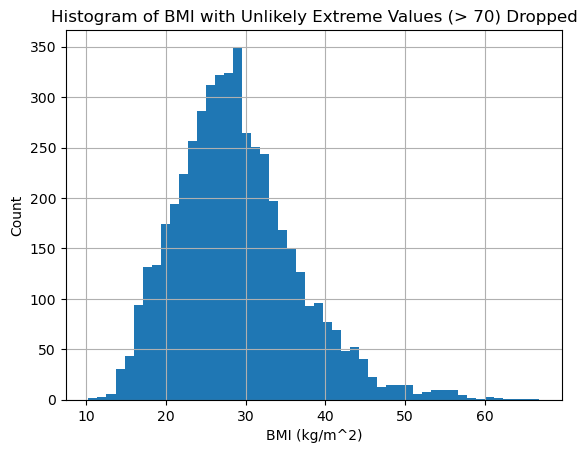

In [16]:
stroke_df["bmi"].hist(bins=50)
plt.xlabel("BMI (kg/m^2)")
plt.ylabel("Count")
plt.title("Histogram of BMI with Unlikely Extreme Values (> 70) Dropped")
plt.show()

Recall the missing values for BMI. Is there any trend to these values relative to the target class? 

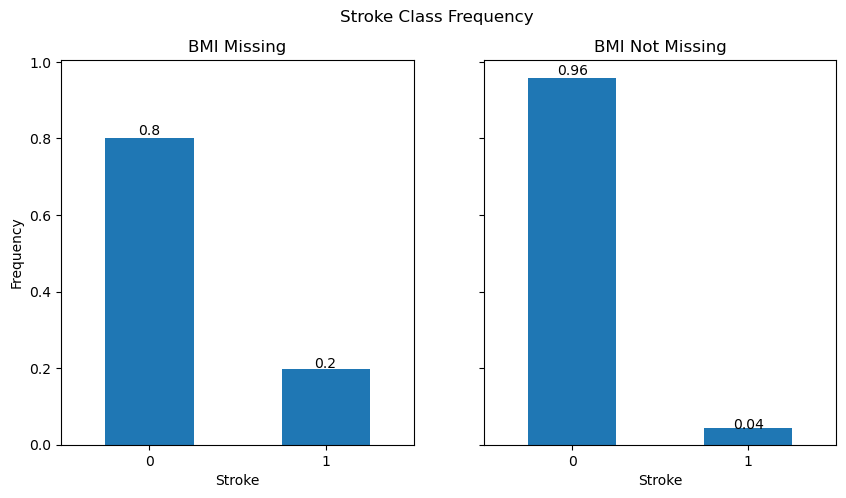

In [17]:
plot_stroke_class_frequency_by_bmi(stroke_df)

note: <br> There are 2 strategies that I can take here. <br> Strategy 1: Impute missing values <br> Strategy 2: Drop missing values <br><br> _Clearly the proportion of the target class differs between the two groups, but does it differ more than chance? I will assess this difference in counts statistically using a Chi-Squared test at an alpha level of 0.05, and if these counts differ beyond what we would assume due to chance, then I will drop these values because then I believe they could provide bias to my models. <br> I would need to consult the institution (i.e. a domain expert) to learn why these values are missing._

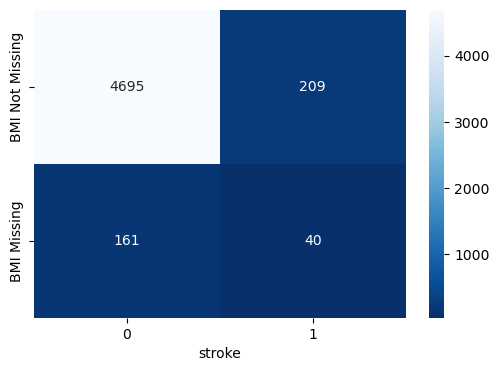

In [18]:
bmi_missing = stroke_df.loc[stroke_df["bmi"].isna()]
bmi_not_missing = stroke_df.loc[~stroke_df["bmi"].isna()]
stroke_counts_not_missing = bmi_not_missing["stroke"].value_counts()
stroke_counts_missing = bmi_missing["stroke"].value_counts()

bmi_stroke_contingency = pd.DataFrame(
    {"BMI Not Missing": stroke_counts_not_missing, "BMI Missing": stroke_counts_missing}
).transpose()

plt.figure(figsize=(6, 4))
sns.heatmap(bmi_stroke_contingency, annot=True, fmt="d", cmap="Blues_r")
plt.show()

In [19]:
chi_2, p, _, expected = stats.chi2_contingency(bmi_stroke_contingency)
print(
    f"Chi-Squared Statistic: {chi_2}, p-value: {p}.\nExpected distribution of counts: \n {expected}"
)

Chi-Squared Statistic: 98.43759864075975, p-value: 3.354297165582099e-23.
Expected distribution of counts: 
 [[4664.80391773  239.19608227]
 [ 191.19608227    9.80391773]]


Due to the fact that these are significantly different distributions than would be expected due to chance, I will proceed to drop observations that contain missing values. 

In [20]:
stroke_df = stroke_df.drop(labels=bmi_missing.index, axis=0)
stroke_df_num = stroke_df[numerical_columns]
pd.DataFrame(stroke_df.isnull().sum(), columns=["null values"])

,null values
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


Next, I will look deeper into the variance of the data and potential outliers:

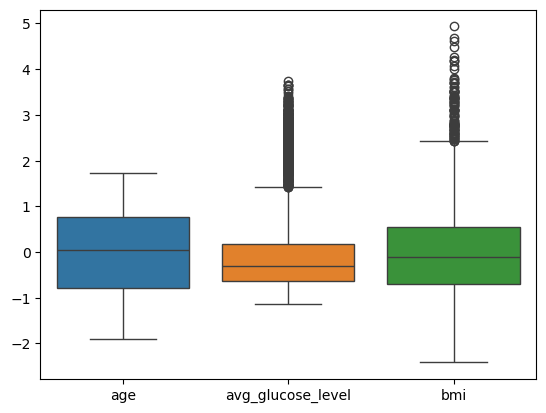

In [21]:
scaler = StandardScaler()
scaled_stroke_num_df = pd.DataFrame(
    scaler.fit_transform(stroke_df[numerical_columns]), columns=numerical_columns
)
ax = sns.boxplot(data=scaled_stroke_num_df)

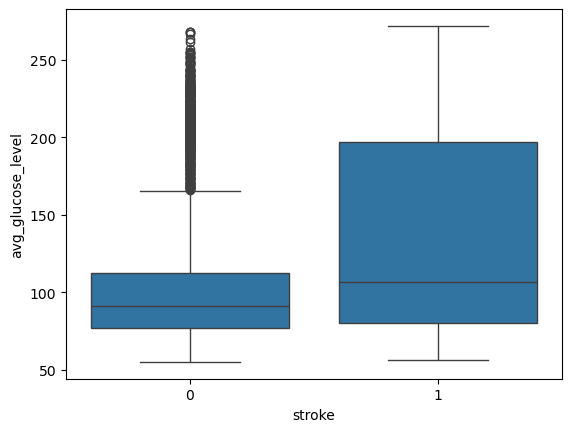

In [22]:
ax = sns.boxplot(data=stroke_df, x="stroke", y="avg_glucose_level")

<Axes: xlabel='avg_glucose_level', ylabel='Count'>

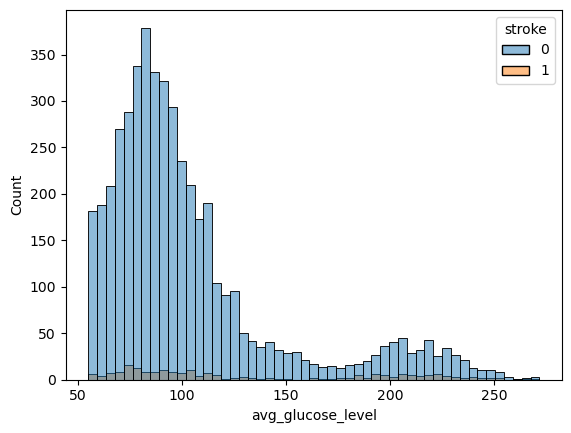

In [23]:
sns.histplot(data=stroke_df, x="avg_glucose_level", hue="stroke")

 __Given the current data, do people who have strokes have higher average glucose levels than people who do not have strokes?__

$H_0$: People who have strokes have the same mean glucose levels as people who do not <br>
$H_1$: People who have strokes have different mean glucose levels than people who do not<br><br>
$\alpha = 0.05$ 

In [24]:
avg_glucose_stroke = stroke_df[stroke_df["stroke"] == 1]["avg_glucose_level"]
avg_glucose_no_stroke = stroke_df[stroke_df["stroke"] == 0]["avg_glucose_level"]

In [25]:
lower_bound, upper_bound = bootstrap_confidence_interval_two_means(
    avg_glucose_stroke, avg_glucose_no_stroke, alpha=0.05, n_bootstrap=1000
)
print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

95% Confidence Interval: (21.80, 39.39)


In [26]:
mean_avg_glucose_perm_diffs_null_distribution = [
    mean_diff_permutation(
        stroke_df["avg_glucose_level"],
        len(avg_glucose_stroke),
        len(avg_glucose_no_stroke),
    )
    for _ in range(1000)
]

In [27]:
best_estimate_of_mean_avg_glucose_differences = (
    avg_glucose_stroke.mean() - avg_glucose_no_stroke.mean()
)
best_estimate_of_mean_avg_glucose_differences

30.57242057365312

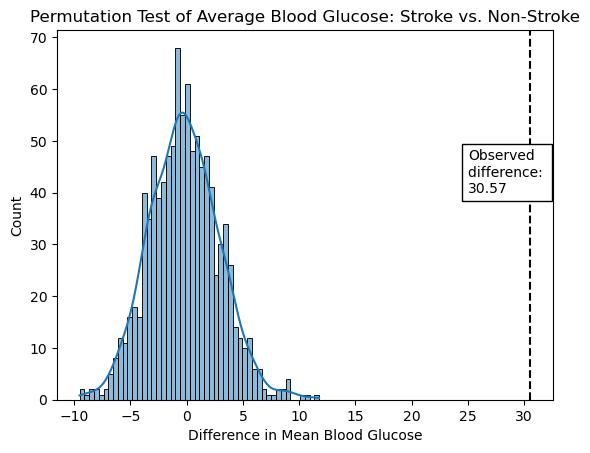

In [28]:
ax = sns.histplot(mean_avg_glucose_perm_diffs_null_distribution, bins=50, kde=True)
ax.axvline(x=best_estimate_of_mean_avg_glucose_differences, color="k", linestyle="--")
ax.text(
    25,
    40,
    f"Observed\ndifference: \n{best_estimate_of_mean_avg_glucose_differences:.2f}",
    bbox={"facecolor": "white"},
)
plt.title("Permutation Test of Average Blood Glucose: Stroke vs. Non-Stroke")
plt.xlabel("Difference in Mean Blood Glucose")
plt.ylabel("Count")
plt.show()

In [29]:
p_value = np.mean(
    [
        diff > best_estimate_of_mean_avg_glucose_differences
        for diff in mean_avg_glucose_perm_diffs_null_distribution
    ]
)
print(
    f"""
According to this permutation test the difference in the means 
that we observed would be observed due to chance {p_value*100:.2f}% of the time, p = {p_value} (i.e. p<0.00001).
"""
)


According to this permutation test the difference in the means 
that we observed would be observed due to chance 0.00% of the time, p = 0.0 (i.e. p<0.00001).



Next, we will do the same thing for BMI

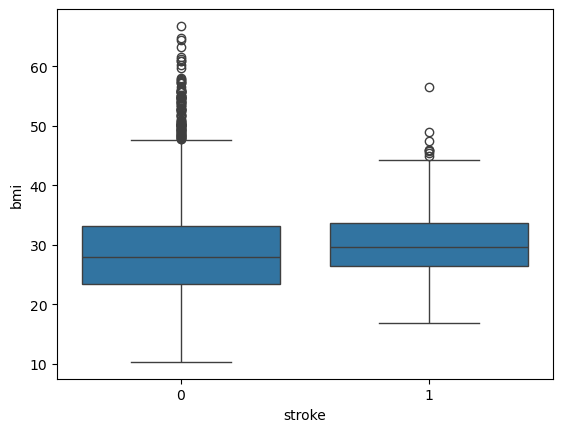

In [30]:
ax = sns.boxplot(data=stroke_df, x="stroke", y="bmi")

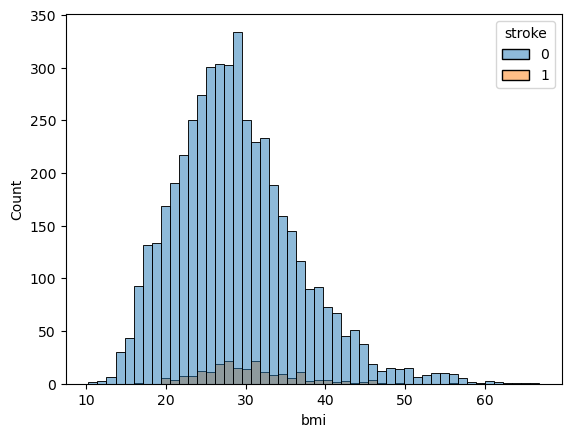

In [31]:
ax = sns.histplot(data=stroke_df, x="bmi", hue="stroke")

$H_0$: People who have strokes have the same mean bmi as people who do not <br>
$H_1$: People who have strokes have different mean bmi than people who do not<br><br>
$\alpha = 0.05$ 

In [32]:
avg_bmi_stroke = stroke_df[stroke_df["stroke"] == 1]["bmi"]
avg_bmi_no_stroke = stroke_df[stroke_df["stroke"] == 0]["bmi"]

In [33]:
lower_bound, upper_bound = bootstrap_confidence_interval_two_means(
    avg_bmi_stroke, avg_bmi_no_stroke, alpha=0.05, n_bootstrap=1000
)
print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

95% Confidence Interval: (0.83, 2.60)


In [34]:
mean_avg_bmi_perm_diffs_null_distribution = [
    mean_diff_permutation(stroke_df["bmi"], len(avg_bmi_stroke), len(avg_bmi_no_stroke))
    for _ in range(1000)
]

In [35]:
best_estimate_of_mean_avg_bmi_differences = (
    avg_bmi_stroke.mean() - avg_bmi_no_stroke.mean()
)

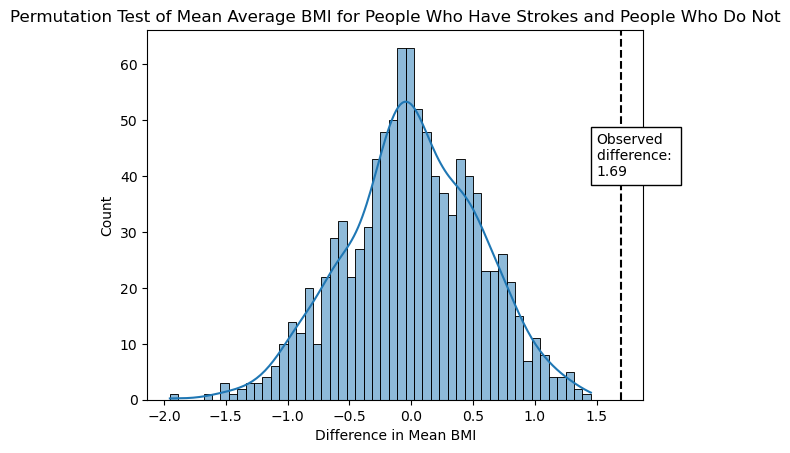

In [36]:
ax = sns.histplot(mean_avg_bmi_perm_diffs_null_distribution, bins=50, kde=True)
ax.axvline(x=best_estimate_of_mean_avg_bmi_differences, color="k", linestyle="--")
ax.text(
    1.5,
    40,
    f"Observed\ndifference: \n{best_estimate_of_mean_avg_bmi_differences:.2f}",
    bbox={"facecolor": "white"},
)
plt.title(
    "Permutation Test of Mean Average BMI for People Who Have Strokes and People Who Do Not"
)
plt.xlabel("Difference in Mean BMI")
plt.ylabel("Count")
plt.show()

In [37]:
p_value = np.mean(
    [
        diff > best_estimate_of_mean_avg_bmi_differences
        for diff in mean_avg_bmi_perm_diffs_null_distribution
    ]
)
print(
    f"""
According to this permutation test the difference in the means 
that we observed would be observed due to chance {p_value*100:.2f}% of the time, p = {p_value}.
"""
)


According to this permutation test the difference in the means 
that we observed would be observed due to chance 0.00% of the time, p = 0.0.



Interim Summary of Statistical Tests:
- the observed difference of +30.57 in mean average blood glucose for stroke patients appears to be unlikely due to chance
- the observed difference of +1.69 in mean BMI for stroke patients also appears to be unlikely due to chance 
- So, on average, stroke patients have a higher blood glucose and BMI

Next, we will investigate some pairwise relationships between these numerical features. 

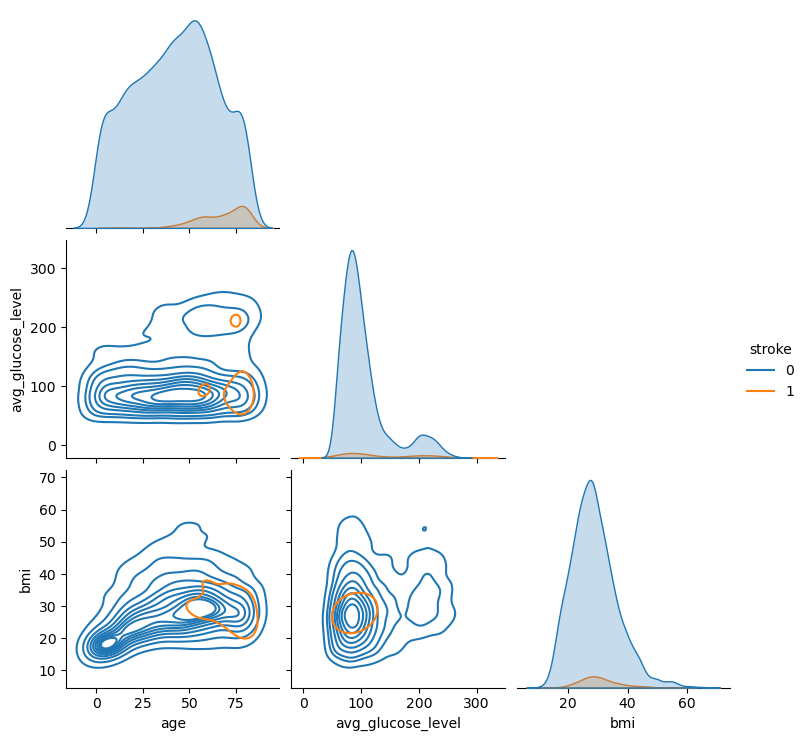

In [38]:
ax = sns.pairplot(
    stroke_df, kind="kde", vars=numerical_columns, hue="stroke", corner=True
)

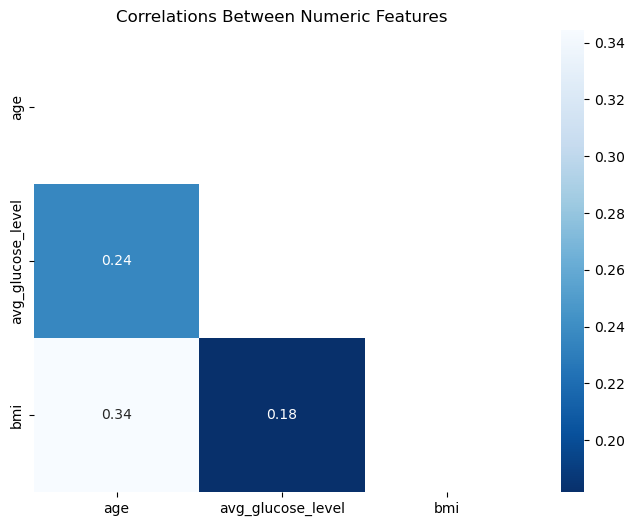

In [39]:
corr = stroke_df_num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="Blues_r", ax=ax)
plt.title("Correlations Between Numeric Features")
plt.show()

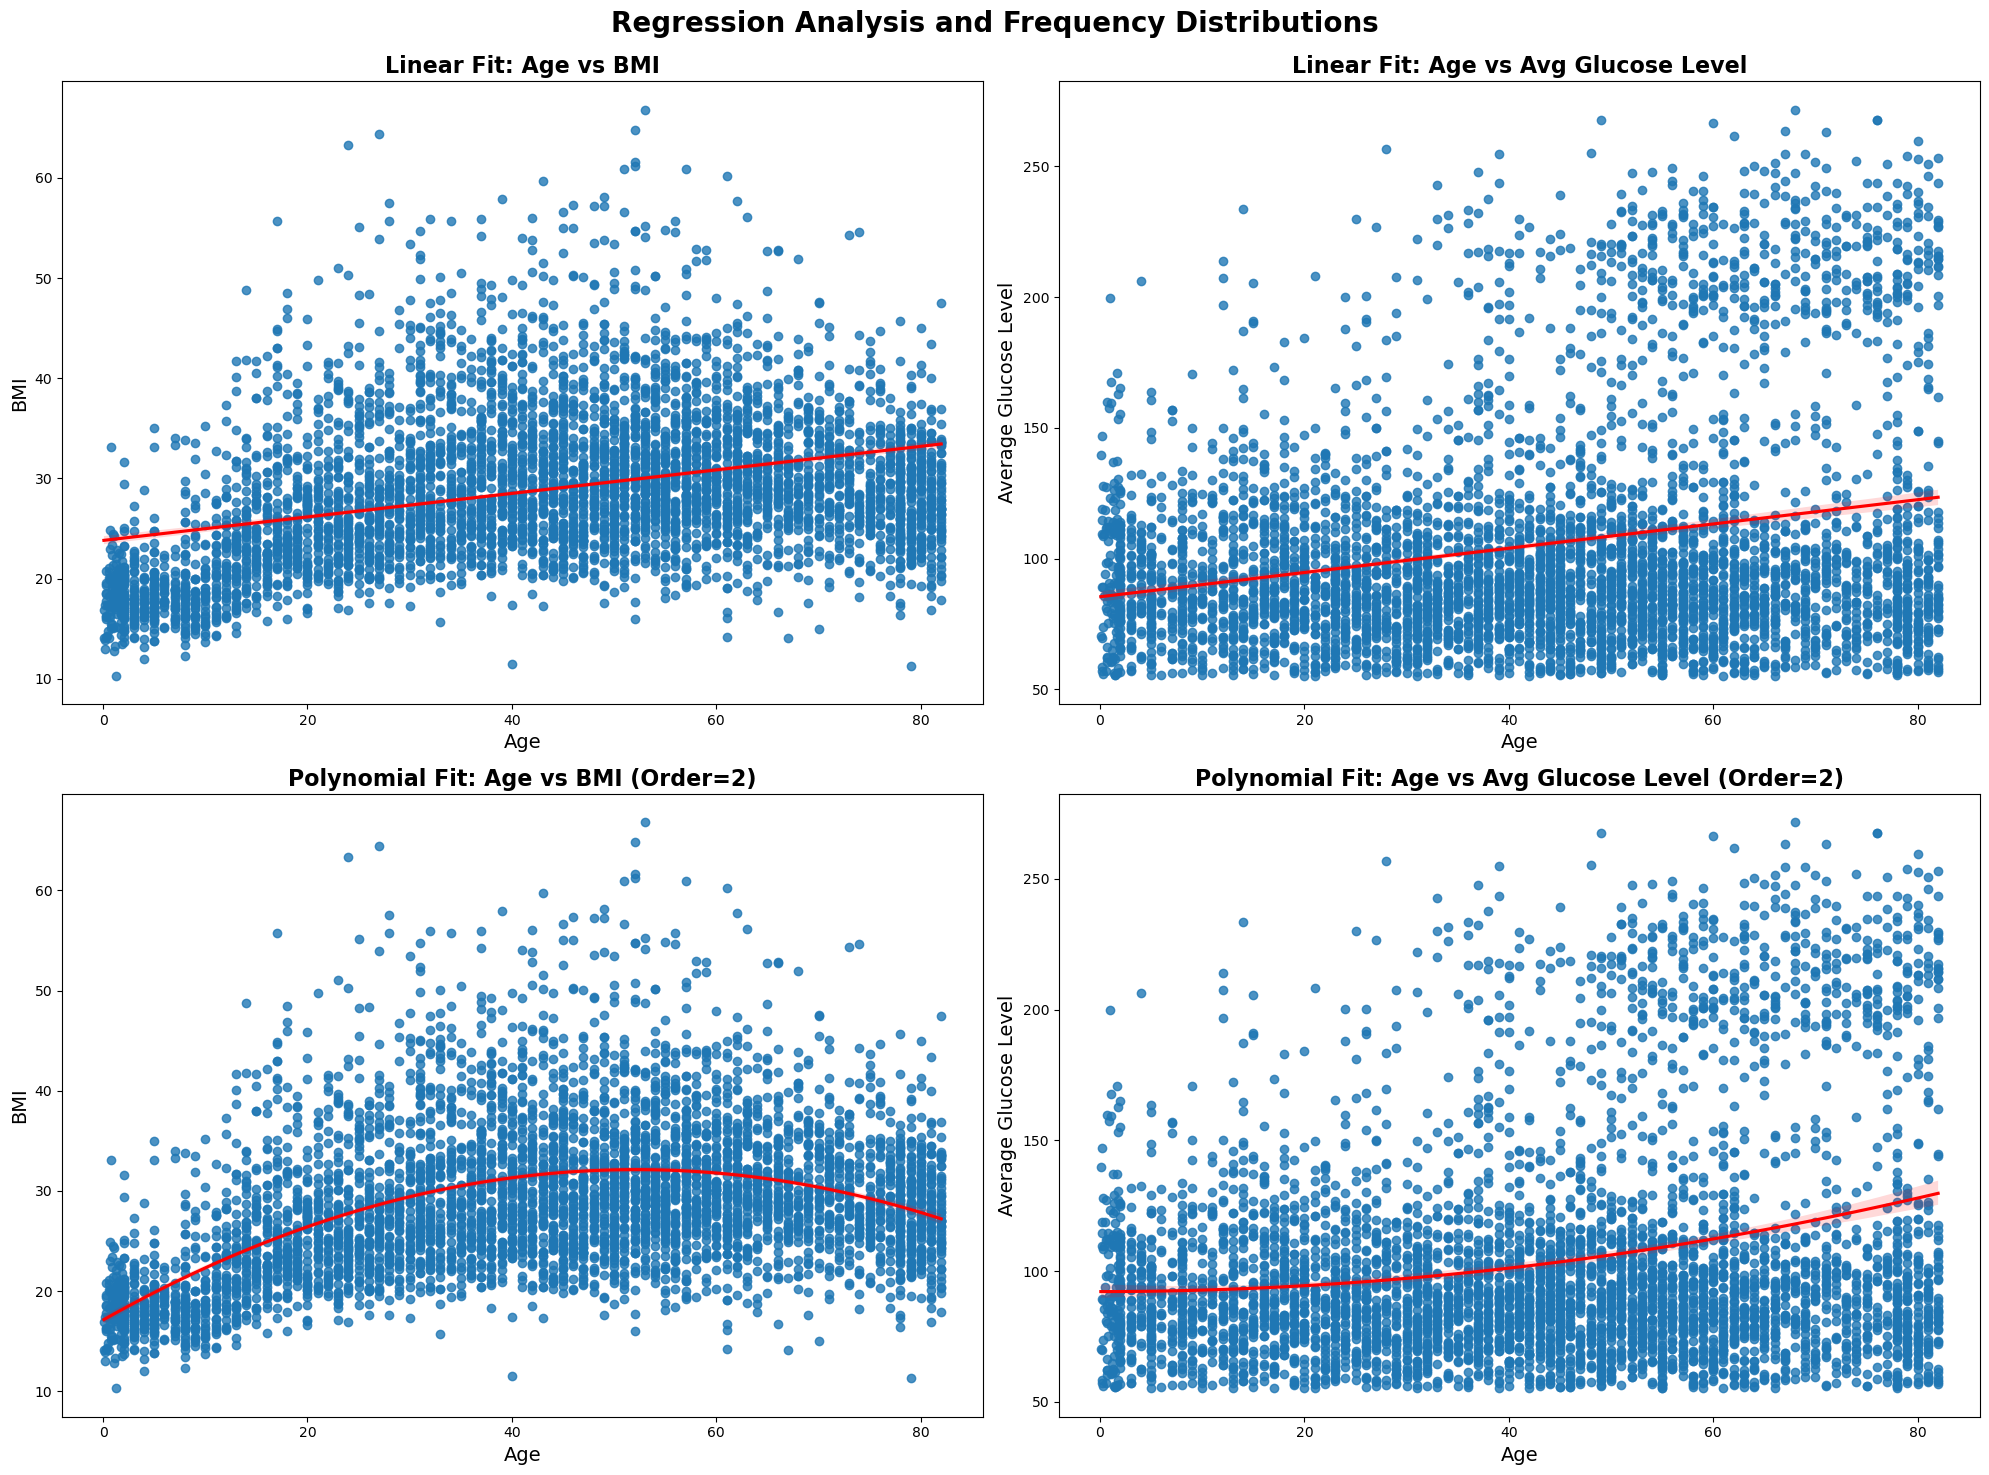

In [40]:
plot_regressions(stroke_df)

Interim Summary of Pairwise Relationships <br><br>
- Age may be modestly correlated to other numerical features. 
- potentially a second-degree polynomial relationship between age and BMI 
- no visually discernible linear relationship between age and average glucose level 
<br><br>
_When considering the target value of stroke:_
- those who have a stroke tend to be older than the center values for BMI and average glucose level 

To see these age-relationships between stroke and non-stroke groups:

In [41]:
bins = [0, 20, 40, 60, 80, 100]
stroke_df["age_bin"] = pd.cut(stroke_df["age"], bins)

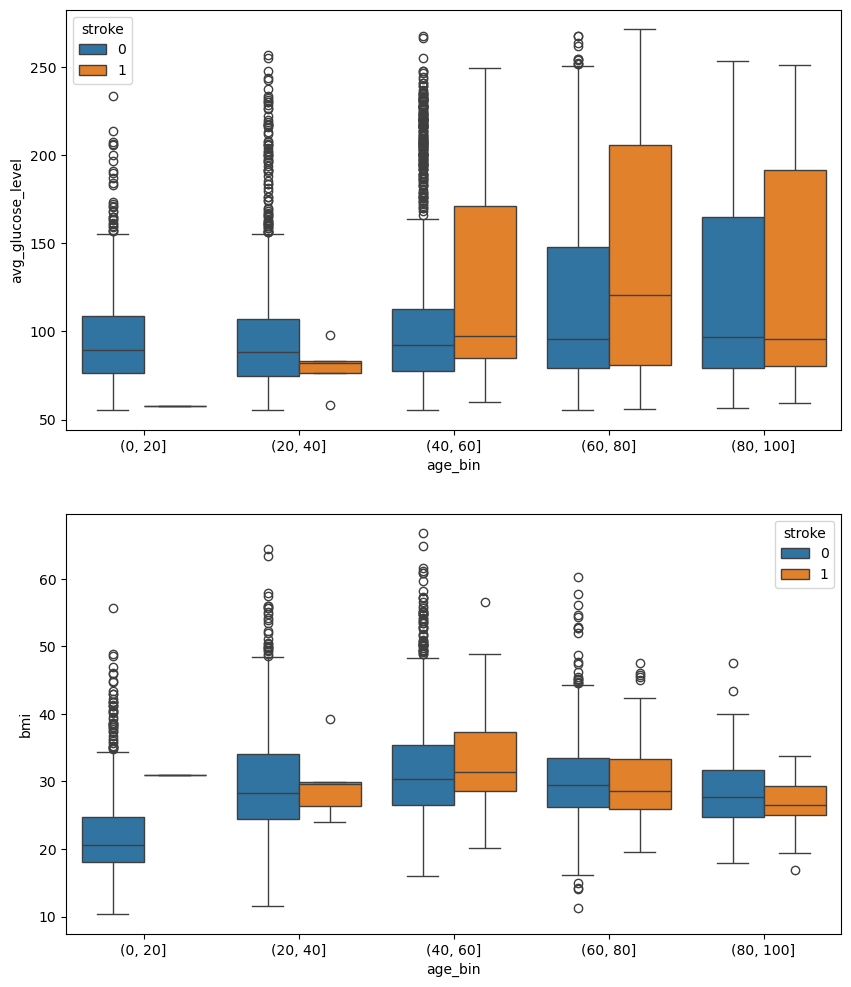

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
sns.boxplot(x="age_bin", y="avg_glucose_level", hue="stroke", data=stroke_df, ax=axs[0])
sns.boxplot(x="age_bin", y="bmi", hue="stroke", data=stroke_df, ax=axs[1])
plt.show()

interim summary: 
- you can see that age interacts with average blood glucose and BMI as age changes. 
- For instance, up to 60 years old stroke patients have a higher BMI than non-stroke, but then this trend flips. Potentially due to the dying of unhealthy BMI patients. 

### Feature to Predict -- Stroke

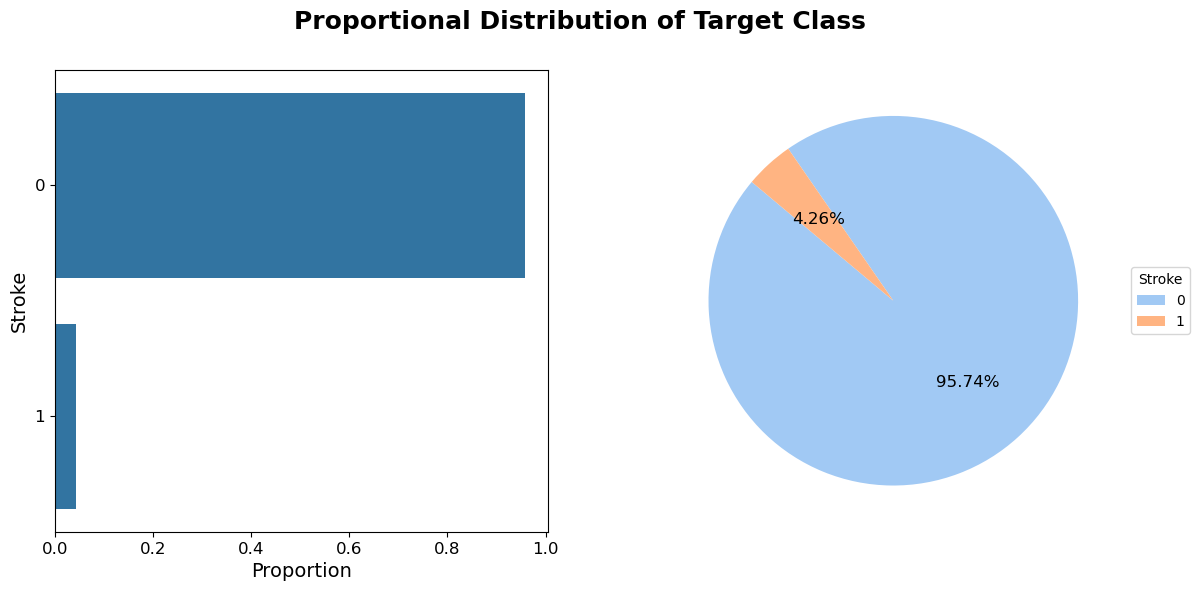

In [43]:
plot_proportional_distribution(stroke_df)

*** 
# Predictive Modeling

In [44]:
df = stroke_df.copy()
X = df.drop(["stroke", "age_bin"], axis=1)
y = df["stroke"]

In [45]:
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked
...,...,...,...,...,...,...,...,...,...,...
5104,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked


In [46]:
numerical_columns = list(X.select_dtypes(include="number"))
categorical_columns = list(X.select_dtypes(include="category"))

Train-Test Split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=1
)

## Linear Models

__Develop Boilerplate Pipelines and Dummy Model Baselines__

In [48]:
set_config(transform_output="pandas")

cat_pipeline = Pipeline([("ohe", OneHotEncoder(drop="first", sparse_output=False))])

num_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
    ]
)

preprocessing = ColumnTransformer(
    [
        ("cat", cat_pipeline, categorical_columns),
        ("num", num_pipeline, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

In [49]:
dummy_model = DummyClassifier()
dummy_pipeline = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", dummy_model)]
)
dummy_accuracy = np.mean(
    cross_val_score(dummy_pipeline, X_train, y_train, cv=5, scoring="accuracy")
)
dummy_auc = np.mean(
    cross_val_score(dummy_pipeline, X_train, y_train, cv=5, scoring="roc_auc")
)
print(f"Dummy Model Accuracy: {dummy_accuracy}")
print(f"Dummy Model ROC: {dummy_auc}")

Dummy Model Accuracy: 0.9574307812296892
Dummy Model ROC: 0.5


In [50]:
weighted_dummy_model = DummyClassifier(strategy="uniform")
weighted_dummy_pipeline = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", weighted_dummy_model)]
)
model_assessment_series_cv(
    weighted_dummy_pipeline, X_train, y_train, model_name="Weighted Dummy Model"
)

Accuracy     0.504464
Precision    0.040379
Recall       0.467380
F1-Score     0.074334
ROC-AUC      0.500000
Name: Weighted Dummy Model, dtype: float64

### Logistic Regression

__Baseline Model__

In [51]:
log_reg_model = LogisticRegression(class_weight="balanced", random_state=0)
log_reg_pipeline = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", log_reg_model)]
)
log_reg_baseline = model_assessment_series_cv(
    log_reg_pipeline, X_train, y_train, model_name="logistic regression - baseline"
)
log_reg_baseline

Accuracy     0.735660
Precision    0.115927
Recall       0.784135
F1-Score     0.201909
ROC-AUC      0.833858
Name: logistic regression - baseline, dtype: float64

In [52]:
poly_log_reg_model = LogisticRegression(class_weight="balanced", random_state=0)
poly_log_reg_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessing),
        ("poly", PolynomialFeatures(degree=2)),
        ("select", SelectKBest(mutual_info_classif, k=15)),
        ("model", poly_log_reg_model),
    ]
)
poly_log_reg_baseline = model_assessment_series_cv(
    poly_log_reg_pipeline,
    X_train,
    y_train,
    model_name="polynomial logistic regression - baseline",
)
poly_log_reg_baseline

Accuracy     0.694872
Precision    0.104056
Recall       0.808378
F1-Score     0.184245
ROC-AUC      0.828796
Name: polynomial logistic regression - baseline, dtype: float64

__What are the regression coefficients?__

In [53]:
log_reg_pipeline.fit(X_train, y_train)

log_reg_coefs = pd.DataFrame(
    log_reg_pipeline[-1].coef_.T,
    index=log_reg_pipeline[-1].feature_names_in_,
    columns=["Coefficients"],
).sort_values(by="Coefficients", ascending=False)
log_reg_coefs

,Coefficients
age,1.692793
smoking_status_smokes,0.730713
hypertension_1,0.657500
heart_disease_1,0.512284
smoking_status_formerly smoked,0.511442
smoking_status_never smoked,0.270985
avg_glucose_level,0.126078
work_type_Private,0.118656
ever_married_Yes,0.095353
bmi,0.045242


In [54]:
poly_log_reg_pipeline.fit(X_train, y_train)

poly_log_reg_coefs = pd.DataFrame(
    poly_log_reg_pipeline[-1].coef_.T,
    index=poly_log_reg_pipeline[-1].feature_names_in_,
    columns=["Coefficients"],
).sort_values(by="Coefficients", ascending=False)
poly_log_reg_coefs

,Coefficients
age,2.286600
hypertension_1 smoking_status_formerly smoked,0.620371
heart_disease_1 age,0.369465
hypertension_1 age,0.307691
work_type_Private age,0.272692
smoking_status_never smoked age,0.253724
heart_disease_1 avg_glucose_level,0.171454
ever_married_Yes avg_glucose_level,0.135445
ever_married_Yes,0.037487
ever_married_Yes^2,0.037487


__Hyperparameter Tuning with GridSearchCV__

_Why optimize for ROC-AUC?_<br><br>
Ultimately, my intention is to optimize for recall because I want to cast a "wide net" and catch all cases of high stroke risk, but I also want a robust model that maximizes the tradeoff between precision and recall and retains explanatory power. By optimizing models for the Area Under the ROC Curve, I don't simply create a model that doesn't miss likely stroke cases, but a model that allows me the flexibility to shift the threshold to maximize the tradeoff between recall and the false positive rate depending on the purpose at-hand. 

In [55]:
log_reg_params = {
    "model__penalty": ["l1", "l2", "elasticnet"],
    "model__C": [0.5, 1.0, 10],
    "model__solver": ["lbfgs", "liblinear", "saga"],
    "model__max_iter": [100, 1000, 10000],
    "model__tol": [0.001, 0.01, 0.1],
}

log_reg_gs = GridSearchCV(
    log_reg_pipeline, param_grid=log_reg_params, cv=5, scoring="roc_auc"
)
log_reg_gs.fit(X_train, y_train)

log_reg_best_params = log_reg_gs.best_params_
print(f"Best Hyperparameters for Logistic Regression: {log_reg_best_params}")

/Users/migueldiaz/anaconda3/envs/ds-mar24/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.83444483 0.83449229 0.83478476
 0.82890969 0.82890969 0.82890969 0.83361168 0.83551786 0.82657028
 0.83418521 0.83419328 0.83416977 0.83501281 0.83499074 0.83447266
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.83444483 0.83449229 0.83478476 0.82548753 0.82548753 0.82486092
 0.83361168 0.83551786 0.82657028 0.83418521 0.83419328 0.83416977
 0.8339997  0.83396996 0.83447266        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.83444483 0.83449229 0.83478476
 0.7833568  0.7833568  0.81771195 0.83361168 0.83551786 0.82657028
 0.83418521 0.83419328 0.83416977 0.8339997  0.83396996 0.83447266
        nan        nan  

Best Hyperparameters for Logistic Regression: {'model__C': 10, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'saga', 'model__tol': 0.1}


In [56]:
log_reg_model = LogisticRegression(
    C=10,
    max_iter=10000,
    penalty="l2",
    solver="saga",
    tol=0.1,
    class_weight="balanced",
    random_state=0,
)
log_reg_pipeline = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", log_reg_model)]
)
log_reg_tuned = model_assessment_series_cv(
    log_reg_pipeline, X_train, y_train, model_name="logistic regression - gs1"
)
pd.concat([log_reg_baseline, log_reg_tuned], axis=1)

,logistic regression - baseline,logistic regression - gs1
Accuracy,0.735660,0.743561
Precision,0.115927,0.114492
Recall,0.784135,0.747950
F1-Score,0.201909,0.198548
ROC-AUC,0.833858,0.833660


In [57]:
log_reg_pipeline.fit(X_train, y_train)

log_reg_coefs = pd.DataFrame(
    log_reg_pipeline[-1].coef_.T,
    index=log_reg_pipeline[-1].feature_names_in_,
    columns=["Coefficients"],
).sort_values(by="Coefficients", ascending=False)
log_reg_coefs

,Coefficients
age,1.704539
smoking_status_formerly smoked,0.773670
smoking_status_smokes,0.765148
hypertension_1,0.550541
heart_disease_1,0.409186
smoking_status_never smoked,0.275122
ever_married_Yes,0.175974
avg_glucose_level,0.168039
bmi,0.066309
work_type_Private,0.050151


There are many attempts at model building and tuning that I am not including in this notebook. For instance, I previously ran my notebook using a different random kernel for my train test split and my grid search led me to a totally different set of parameters. Surprisingly those parameters seem to generalize even to this particular random split of the data. (see below) 

In [58]:
log_reg_model = LogisticRegression(
    C=0.5,
    max_iter=100,
    penalty="l1",
    solver="liblinear",
    tol=0.01,
    class_weight="balanced",
    random_state=0,
)
log_reg_pipeline = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", log_reg_model)]
)
log_reg_tuned_previously = model_assessment_series_cv(
    log_reg_pipeline,
    X_train,
    y_train,
    model_name="logistic regression - previous notebook",
)
pd.concat([log_reg_baseline, log_reg_tuned, log_reg_tuned_previously], axis=1)

,logistic regression - baseline,logistic regression - gs1,logistic regression - previous notebook
Accuracy,0.735660,0.743561,0.735915
Precision,0.115927,0.114492,0.115237
Recall,0.784135,0.747950,0.778075
F1-Score,0.201909,0.198548,0.200679
ROC-AUC,0.833858,0.833660,0.834399


In [59]:
log_reg_pipeline.fit(X_train, y_train)

log_reg_coefs = pd.DataFrame(
    log_reg_pipeline[-1].coef_.T,
    index=log_reg_pipeline[-1].feature_names_in_,
    columns=["Coefficients"],
).sort_values(by="Coefficients", ascending=False)
log_reg_coefs

,Coefficients
age,1.698778
smoking_status_smokes,0.668109
hypertension_1,0.640597
heart_disease_1,0.474855
smoking_status_formerly smoked,0.449311
smoking_status_never smoked,0.204507
avg_glucose_level,0.127608
work_type_Private,0.098002
bmi,0.045916
ever_married_Yes,0.034822


In [60]:
log_reg_params = {
    "model__C": [0.01, 0.1, 0.25, 0.5, 0.75],
}

log_reg_gs = GridSearchCV(
    log_reg_pipeline, param_grid=log_reg_params, cv=5, scoring="roc_auc"
)
log_reg_gs.fit(X_train, y_train)
log_reg_best_params = log_reg_gs.best_params_
print(f"Best hyperparameters for Logistic Regression: {log_reg_best_params}")

Best hyperparameters for Logistic Regression: {'model__C': 0.1}


In [61]:
log_reg_model = LogisticRegression(
    C=0.1,
    max_iter=100,
    penalty="l1",
    solver="liblinear",
    tol=0.01,
    class_weight="balanced",
    random_state=0,
)
log_reg_pipeline = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", log_reg_model)]
)
log_reg_tuned_final = model_assessment_series_cv(
    log_reg_pipeline, X_train, y_train, model_name="logistic regression - final test"
)
pd.concat(
    [log_reg_baseline, log_reg_tuned, log_reg_tuned_previously, log_reg_tuned_final],
    axis=1,
)

,logistic regression - baseline,logistic regression - gs1,logistic regression - previous notebook,logistic regression - final test
Accuracy,0.735660,0.743561,0.735915,0.729033
Precision,0.115927,0.114492,0.115237,0.111755
Recall,0.784135,0.747950,0.778075,0.772371
F1-Score,0.201909,0.198548,0.200679,0.195203
ROC-AUC,0.833858,0.833660,0.834399,0.836073


In [62]:
log_reg_model_final = LogisticRegression(class_weight="balanced", penalty="l2")
log_reg_pipeline_final = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", log_reg_model_final)]
)
log_reg_final = model_assessment_series_cv(
    log_reg_pipeline_final,
    X_train,
    y_train,
    model_name="logistic regression - final choice",
)
log_reg_final

Accuracy     0.735660
Precision    0.115927
Recall       0.784135
F1-Score     0.201909
ROC-AUC      0.833858
Name: logistic regression - final choice, dtype: float64

Based on all of this information I have decided to with the original baseline model. 

_Why did I choose this model?_<br><br>
I chose this model because it has both a high ROC-AUC and a high recall. It generally performs well.

__RandomizedSearchCV for Polynomial Logistic Regression__

In [63]:
poly_log_reg_params = {
    "select__k": stats.randint(5, 15),
    "model__penalty": ["l1", "l2", "elasticnet"],
    "model__C": stats.uniform(0.01, 10),
    "model__solver": ["lbfgs", "liblinear", "saga"],
    "model__max_iter": stats.randint(100, 10000),
    "model__tol": stats.uniform(0.0001, 0.1),
}

poly_log_reg_gs = RandomizedSearchCV(
    poly_log_reg_pipeline,
    param_distributions=poly_log_reg_params,
    n_iter=100,
    cv=5,
    scoring="roc_auc",
    random_state=1,
)

poly_log_reg_gs.fit(X_train, y_train)
poly_log_reg_best_params = poly_log_reg_gs.best_params_
print(
    f"Best Hyperparameters for Polynomial Logistic Regression: {poly_log_reg_best_params}"
)

/Users/migueldiaz/anaconda3/envs/ds-mar24/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.83029072 0.82621193        nan 0.83127954 0.83119696 0.83484817
        nan        nan 0.82616062 0.8304423  0.81460822 0.8270101
 0.83353161        nan 0.8234933  0.83135608 0.83419299 0.81704017
        nan        nan        nan 0.71476151 0.83025948        nan
 0.83447709 0.83658869 0.78781106 0.8316525  0.8278196  0.81567748
        nan 0.81508844 0.835886   0.82271197        nan        nan
 0.81828838 0.83127976 0.82299714 0.82672572        nan        nan
 0.82672299 0.81624732 0.73775504 0.82195288        nan        nan
 0.83158883        nan 0.83355129        nan 0.82973372 0.83607335
 0.83318973        nan        nan        nan 0.81267592        nan
 0.83112787 0.82941198 0.83407713 0.75786217 0.82363355        nan
 0.8327961         nan        nan        nan        nan        nan
        nan        nan   

Best Hyperparameters for Polynomial Logistic Regression: {'model__C': 0.2930648802079461, 'model__max_iter': 2367, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'model__tol': 0.05398310643416529, 'select__k': 13}


In [64]:
poly_log_reg_model_tuned = LogisticRegression(
    class_weight="balanced",
    random_state=0,
    C=4.75,
    max_iter=8000,
    penalty="l1",
    solver="liblinear",
    tol=0.02,
)
poly_log_reg_pipeline_tuned = Pipeline(
    steps=[
        ("preprocessor", preprocessing),
        ("poly", PolynomialFeatures(degree=2)),
        ("select", SelectKBest(mutual_info_classif, k=14)),
        ("model", poly_log_reg_model_tuned),
    ]
)
poly_log_reg_tuned = model_assessment_series_cv(
    poly_log_reg_pipeline_tuned,
    X_train,
    y_train,
    model_name="polynomial logistic regression - tuned",
)
pd.concat([poly_log_reg_baseline, poly_log_reg_tuned, log_reg_final], axis=1)

,polynomial logistic regression - baseline,polynomial logistic regression - tuned,logistic regression - final choice
Accuracy,0.694872,0.691817,0.735660
Precision,0.104056,0.101861,0.115927
Recall,0.808378,0.796257,0.784135
F1-Score,0.184245,0.180532,0.201909
ROC-AUC,0.828796,0.832739,0.833858


Across cross-validation metrics, the tuned pipeline doesn't perform better than the baseline settings. <br><br>
_note: I have also tried to perform feature engineering to convert colinear features from numerical to categorical and did not find that the performance of the algorithm had improved._

In [65]:
poly_log_reg_model_final = LogisticRegression(class_weight="balanced", random_state=0)
poly_log_reg_pipeline_final = Pipeline(
    steps=[
        ("preprocessor", preprocessing),
        ("poly", PolynomialFeatures(degree=2)),
        ("select", SelectKBest(mutual_info_classif, k=15)),
        ("model", poly_log_reg_model),
    ]
)
poly_log_reg_final = model_assessment_series_cv(
    poly_log_reg_pipeline_final,
    X_train,
    y_train,
    model_name="polynomial logistic regression - final",
)
pd.concat([log_reg_final, poly_log_reg_final], axis=1)

,logistic regression - final choice,polynomial logistic regression - final
Accuracy,0.735660,0.690795
Precision,0.115927,0.101974
Recall,0.784135,0.802139
F1-Score,0.201909,0.180848
ROC-AUC,0.833858,0.830792


__Feature Importance__

In [66]:
log_reg_pipeline_final.fit(X_train, y_train)

log_reg_coefs_final = pd.DataFrame(
    log_reg_pipeline_final[-1].coef_.T,
    index=log_reg_pipeline_final[-1].feature_names_in_,
    columns=["Coefficients"],
).sort_values(by="Coefficients", ascending=False)
log_reg_coefs

,Coefficients
age,1.698778
smoking_status_smokes,0.668109
hypertension_1,0.640597
heart_disease_1,0.474855
smoking_status_formerly smoked,0.449311
smoking_status_never smoked,0.204507
avg_glucose_level,0.127608
work_type_Private,0.098002
bmi,0.045916
ever_married_Yes,0.034822


In [67]:
poly_log_reg_pipeline_final.fit(X_train, y_train)

poly_log_reg_coefs_final = pd.DataFrame(
    poly_log_reg_pipeline_final[-1].coef_.T,
    index=poly_log_reg_pipeline_final[-1].feature_names_in_,
    columns=["Coefficients"],
).sort_values(by="Coefficients", ascending=False)
poly_log_reg_coefs_final

,Coefficients
age,2.459634
hypertension_1 ever_married_Yes,0.645112
heart_disease_1 Residence_type_Urban,0.425935
heart_disease_1 age,0.284056
work_type_Private age,0.274407
smoking_status_never smoked age,0.186015
ever_married_Yes avg_glucose_level,0.126949
age avg_glucose_level,0.027866
gender_Male age,0.025423
ever_married_Yes,0.016805


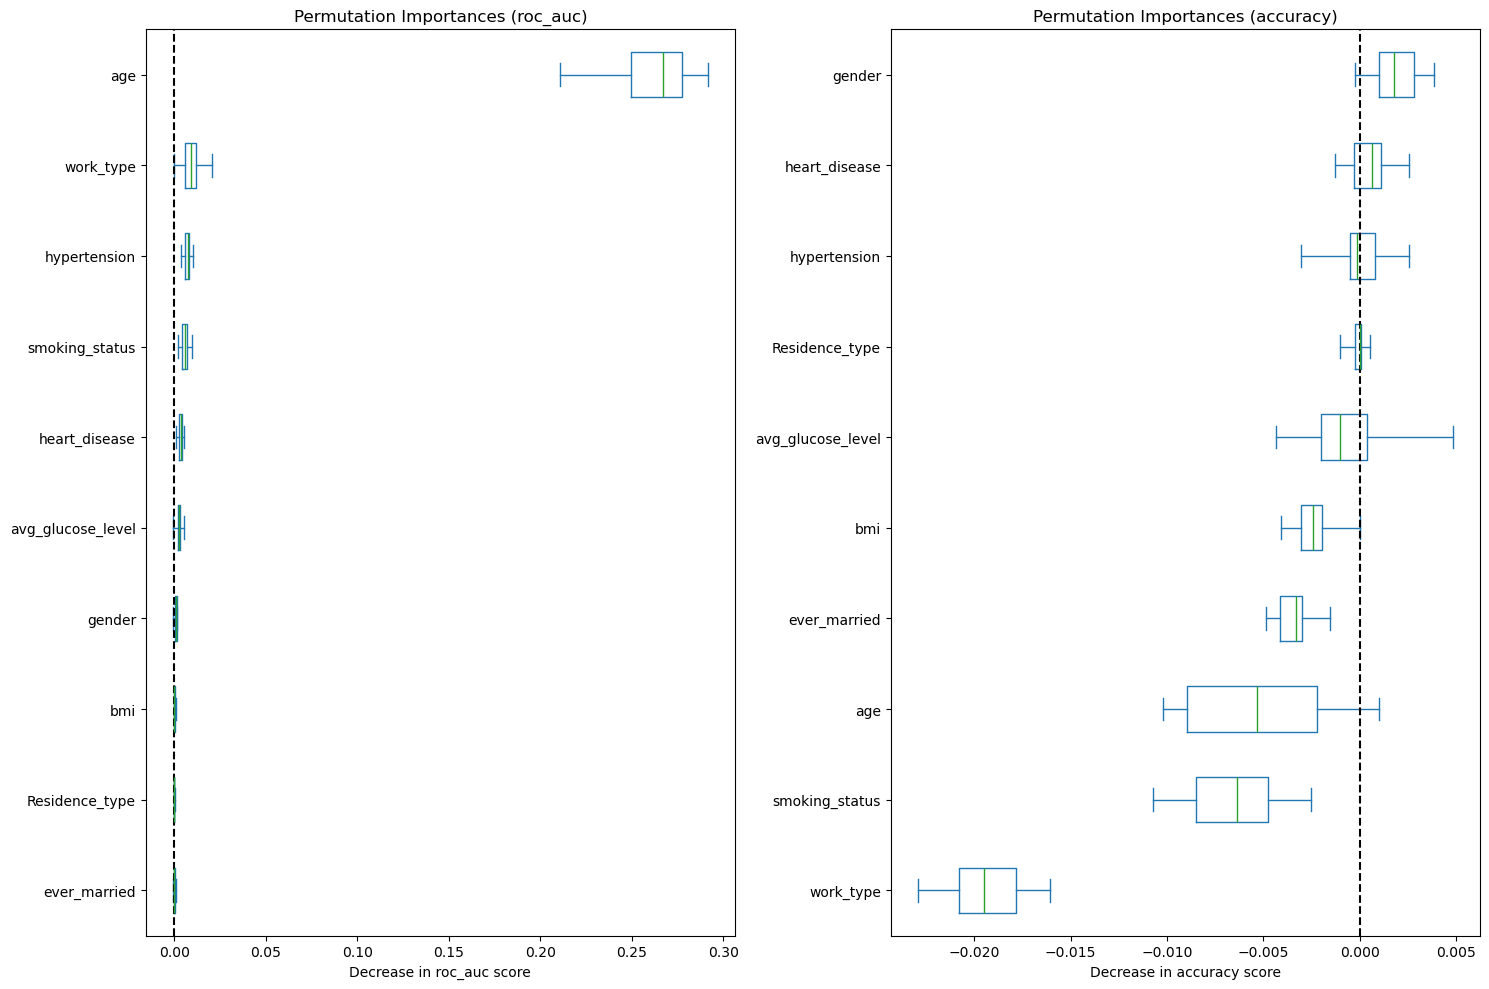

In [68]:
plot_permutation_feature_importance(
    log_reg_pipeline_final, X_train, y_train, metrics=["roc_auc", "accuracy"]
)

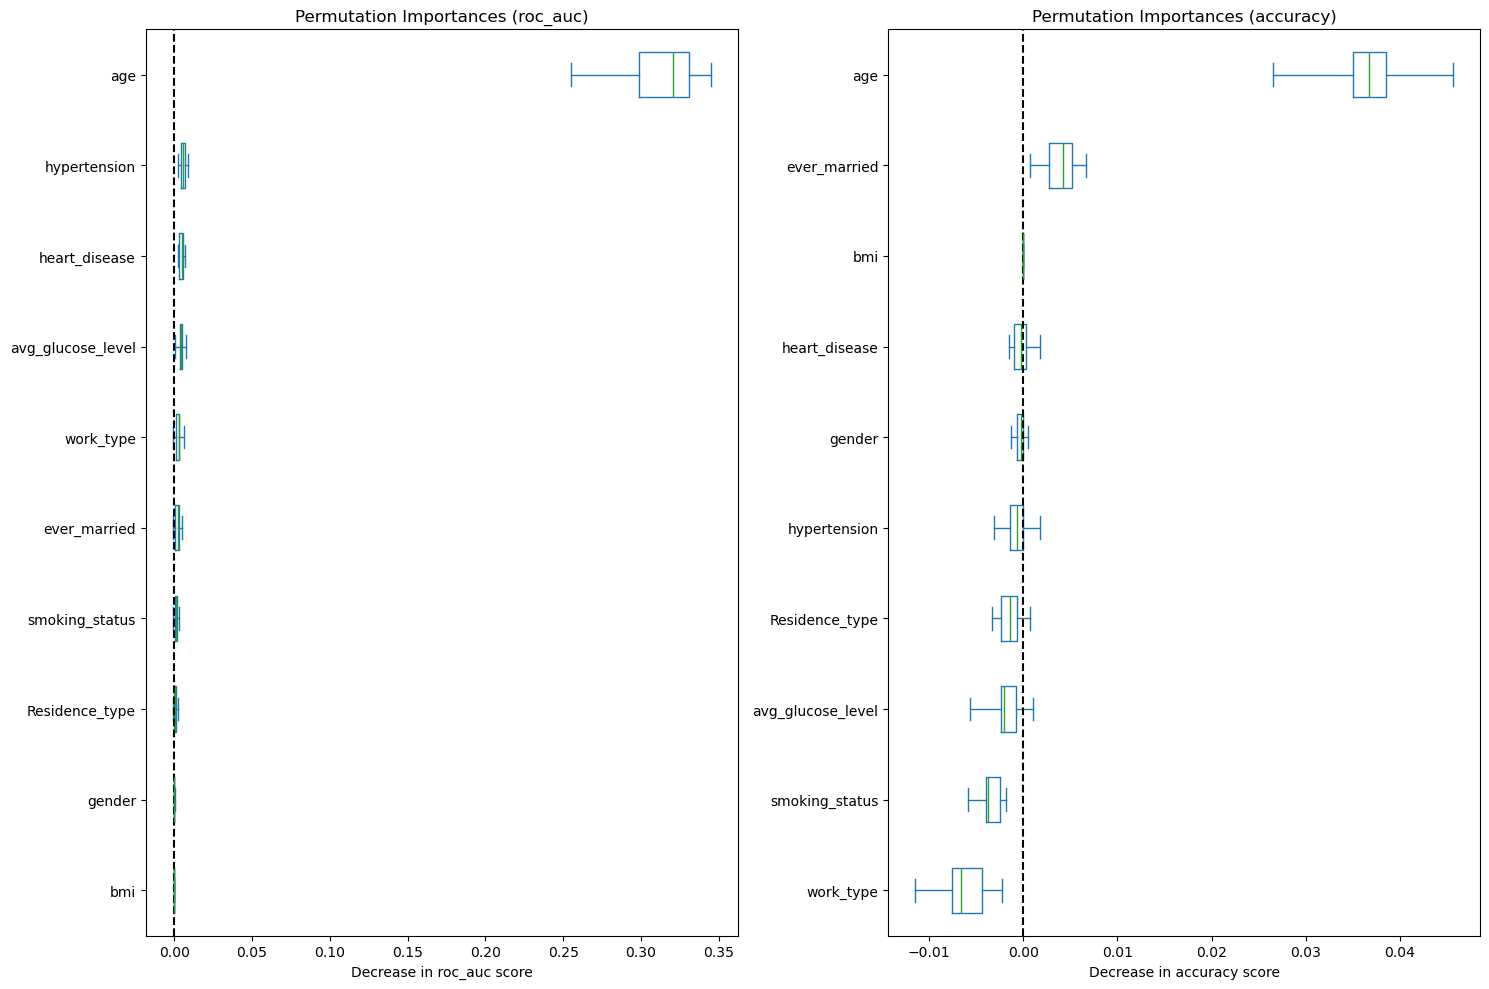

In [69]:
plot_permutation_feature_importance(
    poly_log_reg_pipeline_final, X_train, y_train, metrics=["roc_auc", "accuracy"]
)

__<u>Test Metrics</u>__

In [70]:
log_reg_pipeline_final.fit(X_train, y_train)
log_reg_predictions = log_reg_pipeline_final.predict(X_test)
log_reg_model_assessment = model_assessment_series(
    y_test, log_reg_predictions, "final model test - Logistic Regression"
)
log_reg_model_assessment

Accuracy                      0.741081
Precision                     0.124113
Recall                        0.833333
F1-Score                      0.216049
ROC-AUC (for class labels)    0.785144
Name: final model test - Logistic Regression, dtype: float64

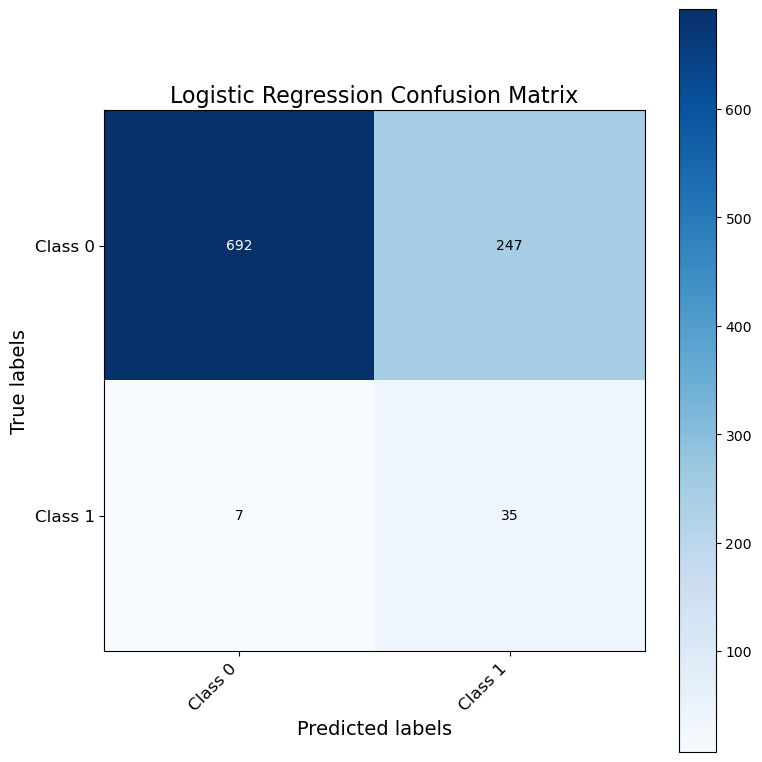

In [71]:
class_names = ["Class 0", "Class 1"]
plot_confusion_matrix(
    y_test,
    log_reg_predictions,
    class_names,
    title="Logistic Regression Confusion Matrix",
)

In [72]:
log_reg_probs = log_reg_pipeline_final.predict_proba(X_test)
log_reg_stroke_probs = log_reg_probs[:, 1]

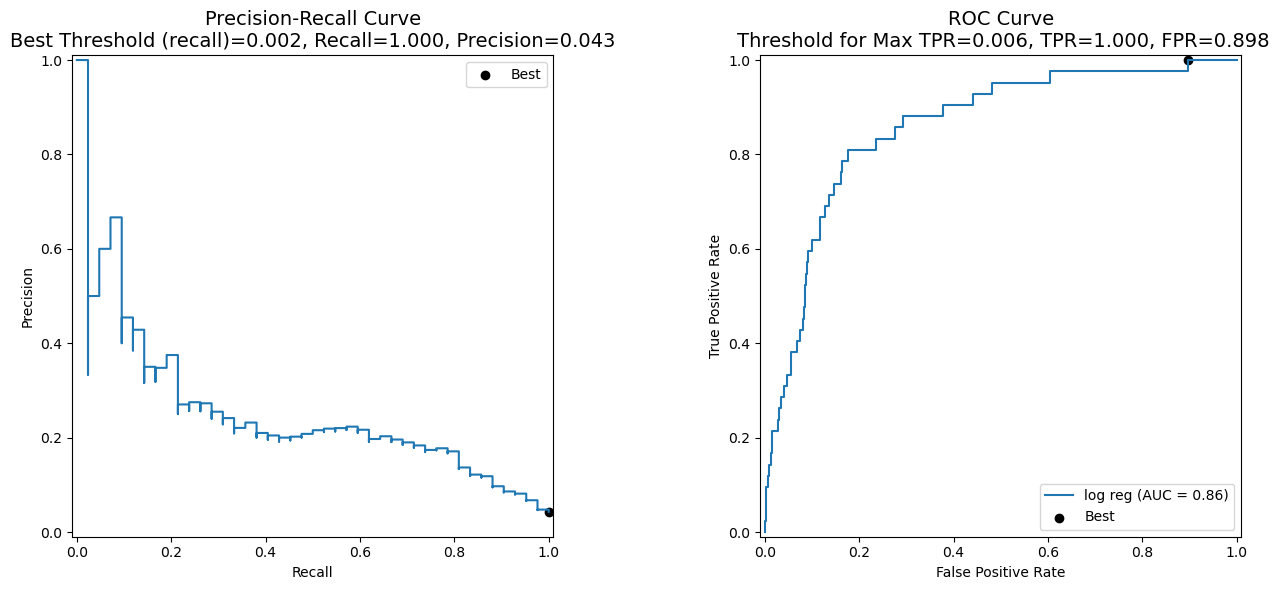

In [73]:
plot_roc_pr_curves_with_best_threshold(y_test, log_reg_stroke_probs, metric="recall")

In [74]:
poly_log_reg_pipeline_final.fit(X_train, y_train)
poly_log_reg_predictions = poly_log_reg_pipeline_final.predict(X_test)
poly_log_reg_model_assessment = model_assessment_series(
    y_test,
    poly_log_reg_predictions,
    "final model test - Polynomial Logistic Regression",
)
poly_log_reg_model_assessment

Accuracy                      0.709480
Precision                     0.116719
Recall                        0.880952
F1-Score                      0.206128
ROC-AUC (for class labels)    0.791381
Name: final model test - Polynomial Logistic Regression, dtype: float64

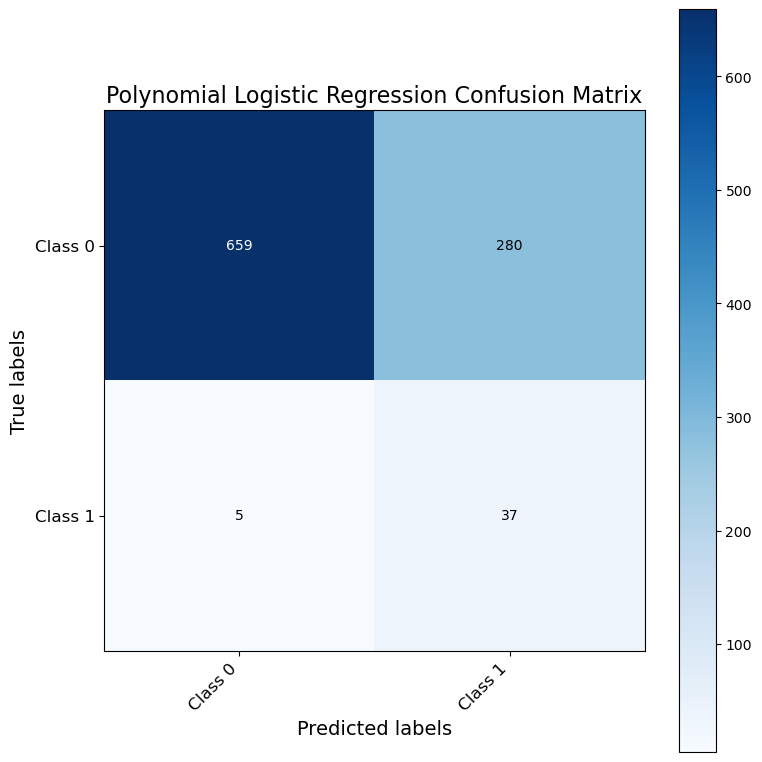

In [75]:
plot_confusion_matrix(
    y_test,
    poly_log_reg_predictions,
    class_names,
    title="Polynomial Logistic Regression Confusion Matrix",
)

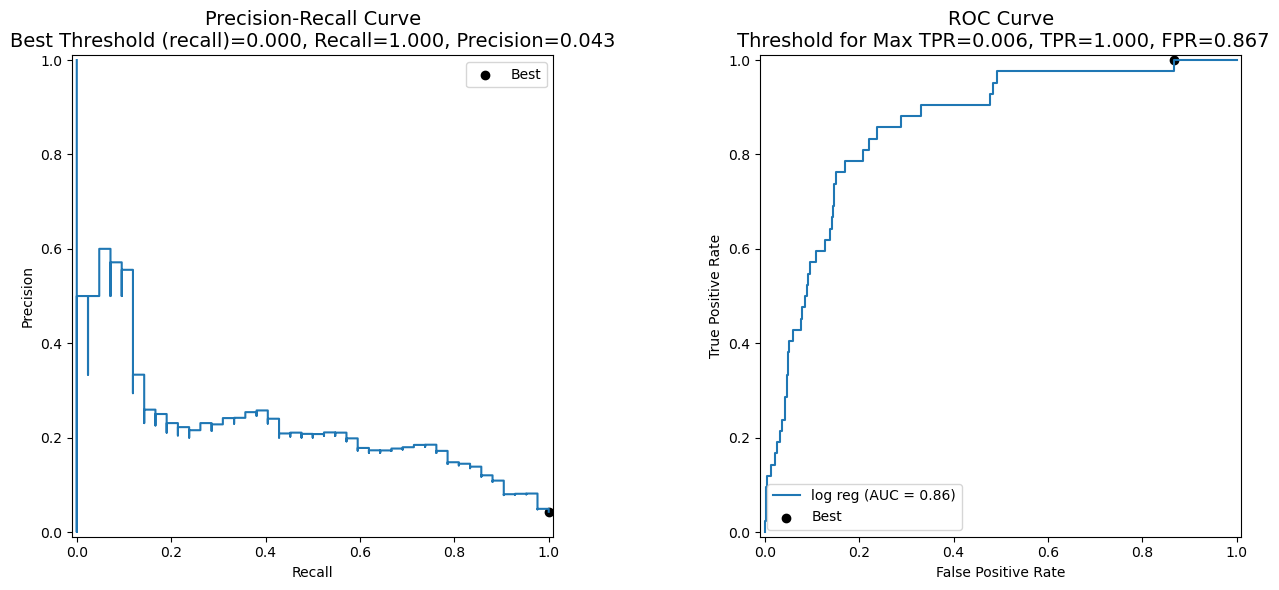

In [76]:
poly_log_reg_probs = poly_log_reg_pipeline_final.predict_proba(X_test)
poly_log_reg_stroke_probs = poly_log_reg_probs[:, 1]
plot_roc_pr_curves_with_best_threshold(
    y_test, poly_log_reg_stroke_probs, metric="recall"
)

### Support Vector Classifier

In [77]:
linear_svc_model = LinearSVC(class_weight="balanced", dual="auto")
linear_svc_pipeline = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", linear_svc_model)]
)
linear_svc_pipeline.fit(X_train, y_train)
linear_svc_baseline = model_assessment_series_cv(
    linear_svc_pipeline, X_train, y_train, folds=5, model_name="linear svc - baseline"
)
linear_svc_baseline

Accuracy     0.729542
Precision    0.113482
Recall       0.784135
F1-Score     0.198192
ROC-AUC      0.834864
Name: linear svc - baseline, dtype: float64

In [78]:
kernel_svc_model = SVC(class_weight="balanced", kernel="rbf")
kernel_svc_pipeline = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", kernel_svc_model)]
)
kernel_svc_pipeline.fit(X_train, y_train)
kernel_svc_baseline = model_assessment_series_cv(
    kernel_svc_pipeline, X_train, y_train, folds=5, model_name="kernel svc - baseline"
)
kernel_svc_baseline

Accuracy     0.776696
Precision    0.104215
Recall       0.557576
F1-Score     0.175462
ROC-AUC      0.777328
Name: kernel svc - baseline, dtype: float64

__Hyperparameter Tuning using GridSearchCV__

In [79]:
linear_svc_grid = {
    "model__C": [0.01, 0.1, 1, 10, 100],
}

linear_svc_gs = GridSearchCV(
    linear_svc_pipeline, linear_svc_grid, cv=5, scoring="roc_auc", n_jobs=-1
)
linear_svc_gs.fit(X_train, y_train)

linear_svc_gs.best_params_

{'model__C': 0.01}

In [80]:
linear_svc_model_tuned = LinearSVC(class_weight="balanced", dual="auto", C=0.01)
linear_svc_pipeline_tuned = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", linear_svc_model_tuned)]
)
linear_svc_pipeline_tuned.fit(X_train, y_train)
linear_svc_tuned = model_assessment_series_cv(
    linear_svc_pipeline_tuned,
    X_train,
    y_train,
    folds=5,
    model_name="linear svc - regularized",
)
pd.concat([linear_svc_baseline, linear_svc_tuned], axis=1)

,linear svc - baseline,linear svc - regularized
Accuracy,0.729542,0.722915
Precision,0.113482,0.110899
Recall,0.784135,0.784314
F1-Score,0.198192,0.194267
ROC-AUC,0.834864,0.836536


In [81]:
kernel_svc_grid = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
}

kernel_svc_gs = GridSearchCV(
    kernel_svc_pipeline, kernel_svc_grid, cv=5, scoring="roc_auc", n_jobs=-1
)
kernel_svc_gs.fit(X_train, y_train)

kernel_svc_gs.best_params_

{'model__C': 0.1, 'model__gamma': 0.01}

In [82]:
kernel_svc_model_tuned = SVC(class_weight="balanced", kernel="rbf", C=0.1, gamma=0.01)
kernel_svc_pipeline_tuned = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", kernel_svc_model_tuned)]
)
kernel_svc_pipeline_tuned.fit(X_train, y_train)
kernel_svc_tuned = model_assessment_series_cv(
    kernel_svc_pipeline_tuned,
    X_train,
    y_train,
    folds=5,
    model_name="kernel svc - tuned",
)
pd.concat([kernel_svc_baseline, kernel_svc_tuned], axis=1)

,kernel svc - baseline,kernel svc - tuned
Accuracy,0.776696,0.671671
Precision,0.104215,0.100117
Recall,0.557576,0.837968
F1-Score,0.175462,0.178810
ROC-AUC,0.777328,0.837028


__Feature Importance__

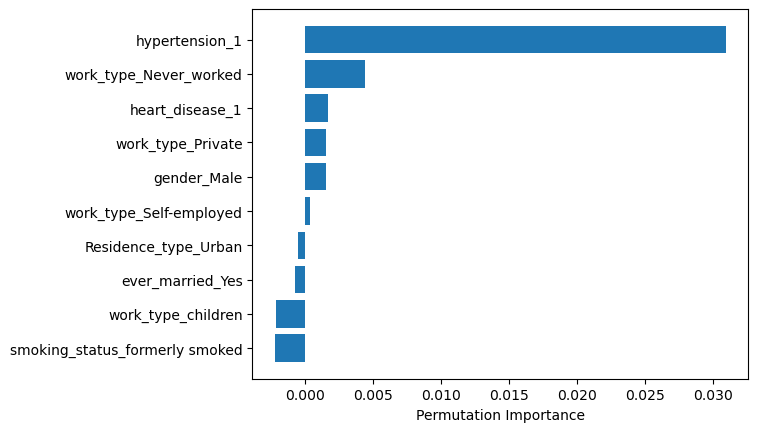

In [83]:
linear_svc_pipeline_tuned.fit(X_train, y_train)
perm_importance = permutation_importance(linear_svc_pipeline_tuned, X_train, y_train)

feature_names = linear_svc_pipeline_tuned[-1].feature_names_in_
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Text(0.5, 0, 'Permutation Importance')

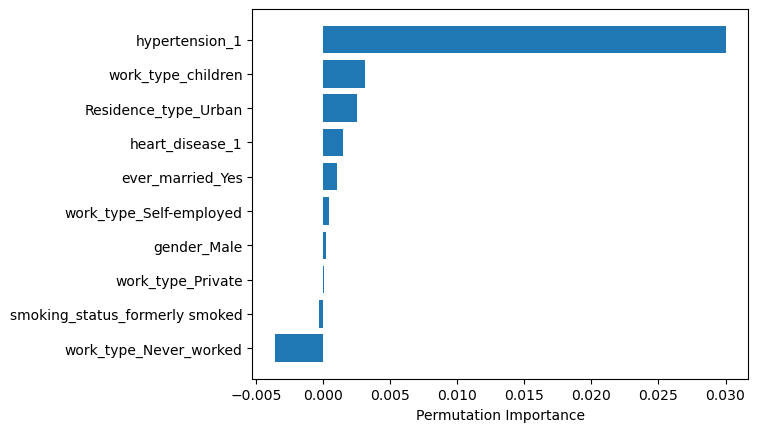

In [84]:
kernel_svc_pipeline_tuned.fit(X_train, y_train)
perm_importance = permutation_importance(kernel_svc_pipeline_tuned, X_train, y_train)

feature_names = kernel_svc_pipeline_tuned[-1].feature_names_in_
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

__<u>Test Metrics</u>__

In [85]:
linear_svc_pipeline_tuned.fit(X_train, y_train)
linear_svc_predictions = linear_svc_pipeline_tuned.predict(X_test)
linear_svc_model_assessment = model_assessment_series(
    y_test, linear_svc_predictions, "final model test - Linear SVC"
)
linear_svc_model_assessment

Accuracy                      0.733945
Precision                     0.121107
Recall                        0.833333
F1-Score                      0.211480
ROC-AUC (for class labels)    0.781416
Name: final model test - Linear SVC, dtype: float64

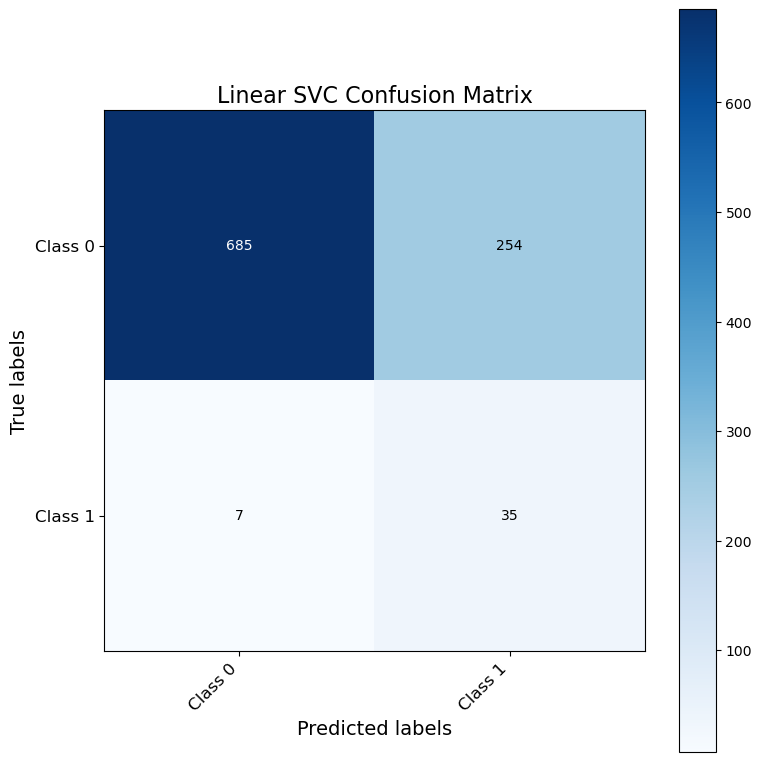

In [86]:
plot_confusion_matrix(
    y_test, linear_svc_predictions, class_names, title="Linear SVC Confusion Matrix"
)

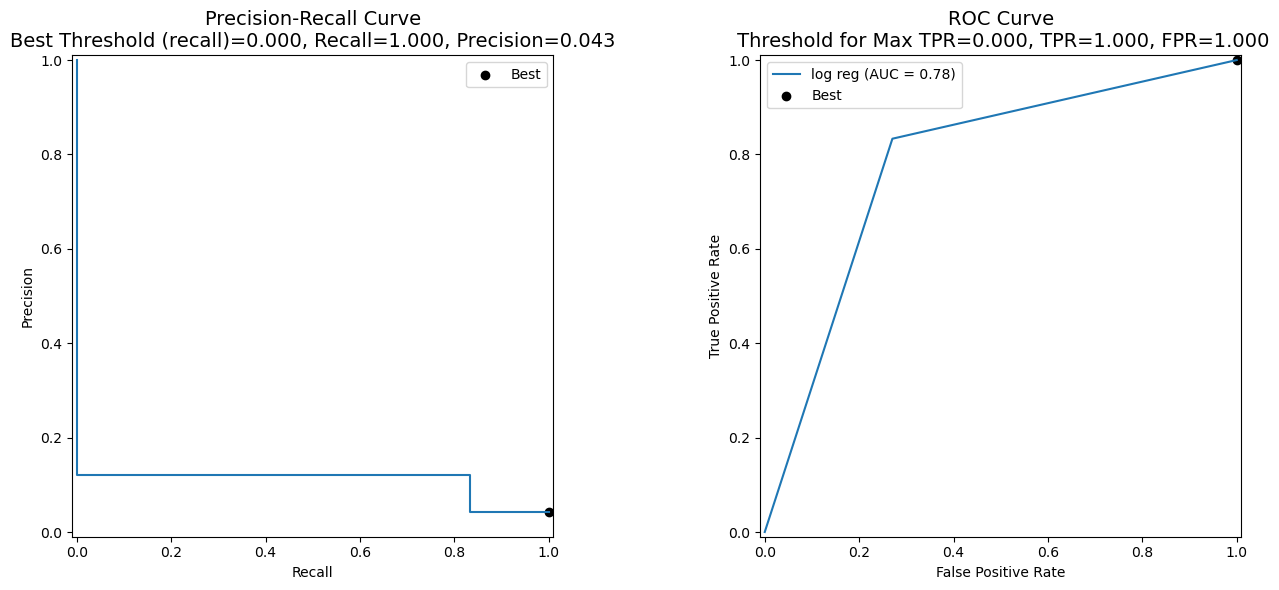

In [87]:
plot_roc_pr_curves_with_best_threshold(y_test, linear_svc_predictions, metric="recall")

In [88]:
kernel_svc_pipeline_tuned.fit(X_train, y_train)
kernel_svc_predictions = kernel_svc_pipeline_tuned.predict(X_test)
kernel_svc_model_assessment = model_assessment_series(
    y_test, kernel_svc_predictions, "final model test - Kernel SVC"
)
kernel_svc_model_assessment

Accuracy                      0.689093
Precision                     0.107463
Recall                        0.857143
F1-Score                      0.190981
ROC-AUC (for class labels)    0.769360
Name: final model test - Kernel SVC, dtype: float64

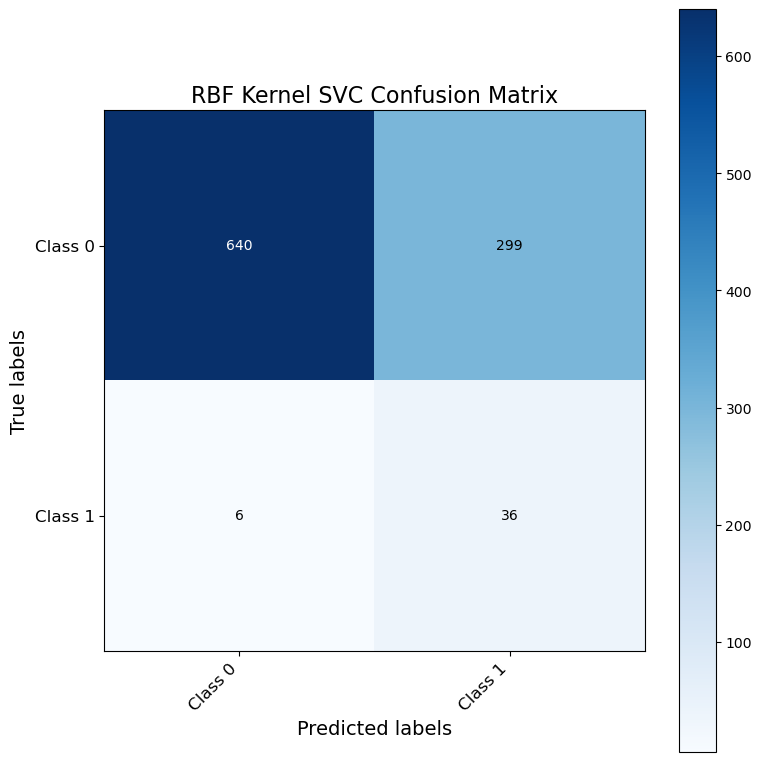

In [89]:
plot_confusion_matrix(
    y_test, kernel_svc_predictions, class_names, title="RBF Kernel SVC Confusion Matrix"
)

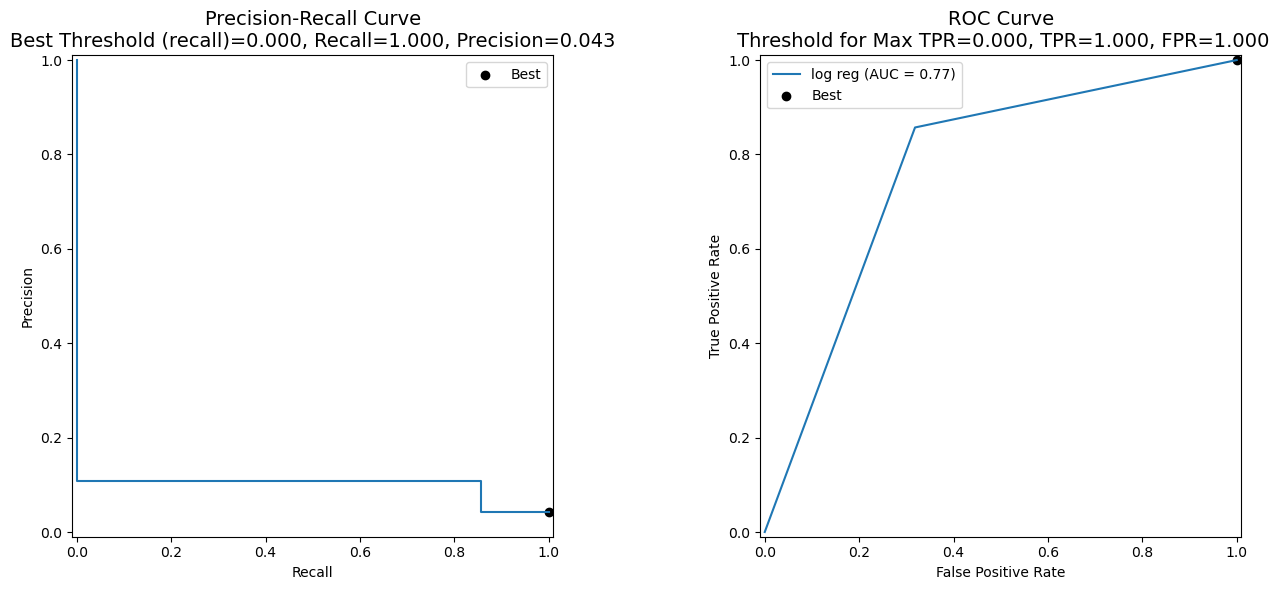

In [90]:
plot_roc_pr_curves_with_best_threshold(y_test, kernel_svc_predictions, metric="recall")

In [91]:
pd.concat(
    [
        log_reg_model_assessment,
        poly_log_reg_model_assessment,
        linear_svc_model_assessment,
        kernel_svc_model_assessment,
    ],
    axis=1,
)

,final model test - Logistic Regression,final model test - Polynomial Logistic Regression,final model test - Linear SVC,final model test - Kernel SVC
Accuracy,0.741081,0.709480,0.733945,0.689093
Precision,0.124113,0.116719,0.121107,0.107463
Recall,0.833333,0.880952,0.833333,0.857143
F1-Score,0.216049,0.206128,0.211480,0.190981
ROC-AUC (for class labels),0.785144,0.791381,0.781416,0.769360


## Tree-Based Models

For tree-based models, I will perform one hot encode features without dropping a column

In [92]:
set_config(transform_output="pandas")

cat_pipeline = Pipeline([("ohe", OneHotEncoder(sparse_output=False))])

num_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
    ]
)

preprocessing = ColumnTransformer(
    [
        ("cat", cat_pipeline, categorical_columns),
        ("num", num_pipeline, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

### Decision Tree

In [93]:
dt_model = DecisionTreeClassifier(class_weight="balanced", random_state=0)
dt_pipeline = Pipeline(steps=[("preprocessor", preprocessing), ("model", dt_model)])
dt_pipeline.fit(X_train, y_train)
dt_baseline = model_assessment_series_cv(
    dt_pipeline, X_train, y_train, folds=5, model_name="decision tree - baseline"
)
dt_baseline

Accuracy     0.929897
Precision    0.156947
Recall       0.143494
F1-Score     0.148446
ROC-AUC      0.554174
Name: decision tree - baseline, dtype: float64

__Hyperparameter Tuning with GridSearchCV__

In [94]:
dt_params = {
    "model__criterion": ["gini", "entropy"],
    "model__splitter": ["best", "random"],
    "model__max_depth": [None, 10, 20, 30, 40, 50],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 10],
    "model__max_features": [None, "sqrt", "log2"],
}

dt_gs = GridSearchCV(
    dt_pipeline, param_grid=dt_params, cv=5, scoring="roc_auc", n_jobs=-1
)
dt_gs.fit(X_train, y_train)
dt_best_params = dt_gs.best_params_
print(f"Best hyperparameters for Decision Tree: {dt_best_params}")

Best hyperparameters for Decision Tree: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 2, 'model__splitter': 'random'}


In [95]:
dt_model_tuned = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=0,
    criterion="entropy",
    max_depth=10,
    max_features="sqrt",
    min_samples_leaf=10,
    min_samples_split=2,
    splitter="random",
)
dt_pipeline_tuned = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", dt_model_tuned)]
)
dt_pipeline_tuned.fit(X_train, y_train)
dt_tuned = model_assessment_series_cv(
    dt_pipeline_tuned, X_train, y_train, folds=5, model_name="decision tree - tuned"
)
pd.concat([dt_baseline, dt_tuned], axis=1)

,decision tree - baseline,decision tree - tuned
Accuracy,0.929897,0.671399
Precision,0.156947,0.087869
Recall,0.143494,0.706952
F1-Score,0.148446,0.155551
ROC-AUC,0.554174,0.724373


notice, although this model is less accurate, it does perform notably better on the key criteria that I am interested in, recall and ROC-AUC. With proper threshold tuning I can find an even better recall performance.

__Feature Importance__

In [96]:
gini_importance = pd.DataFrame(
    dt_pipeline_tuned[-1].feature_importances_,
    index=dt_pipeline_tuned[-1].feature_names_in_,
    columns=["gini"],
).sort_values(by="gini", ascending=False)
gini_importance

,gini
age,0.255949
ever_married_Yes,0.212610
hypertension_1,0.082788
smoking_status_Unknown,0.074263
Residence_type_Urban,0.053751
avg_glucose_level,0.043835
heart_disease_1,0.040588
smoking_status_smokes,0.040084
gender_Male,0.029465
bmi,0.028274


<Axes: xlabel='gini', ylabel='None'>

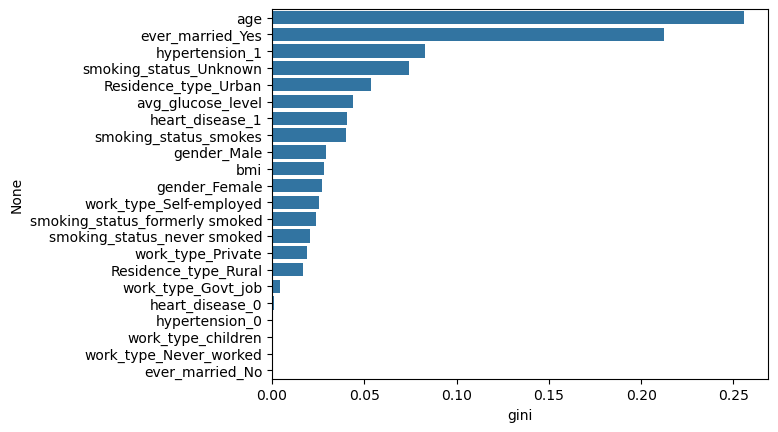

In [97]:
sns.barplot(gini_importance, y=gini_importance.index, x="gini", orient="h")

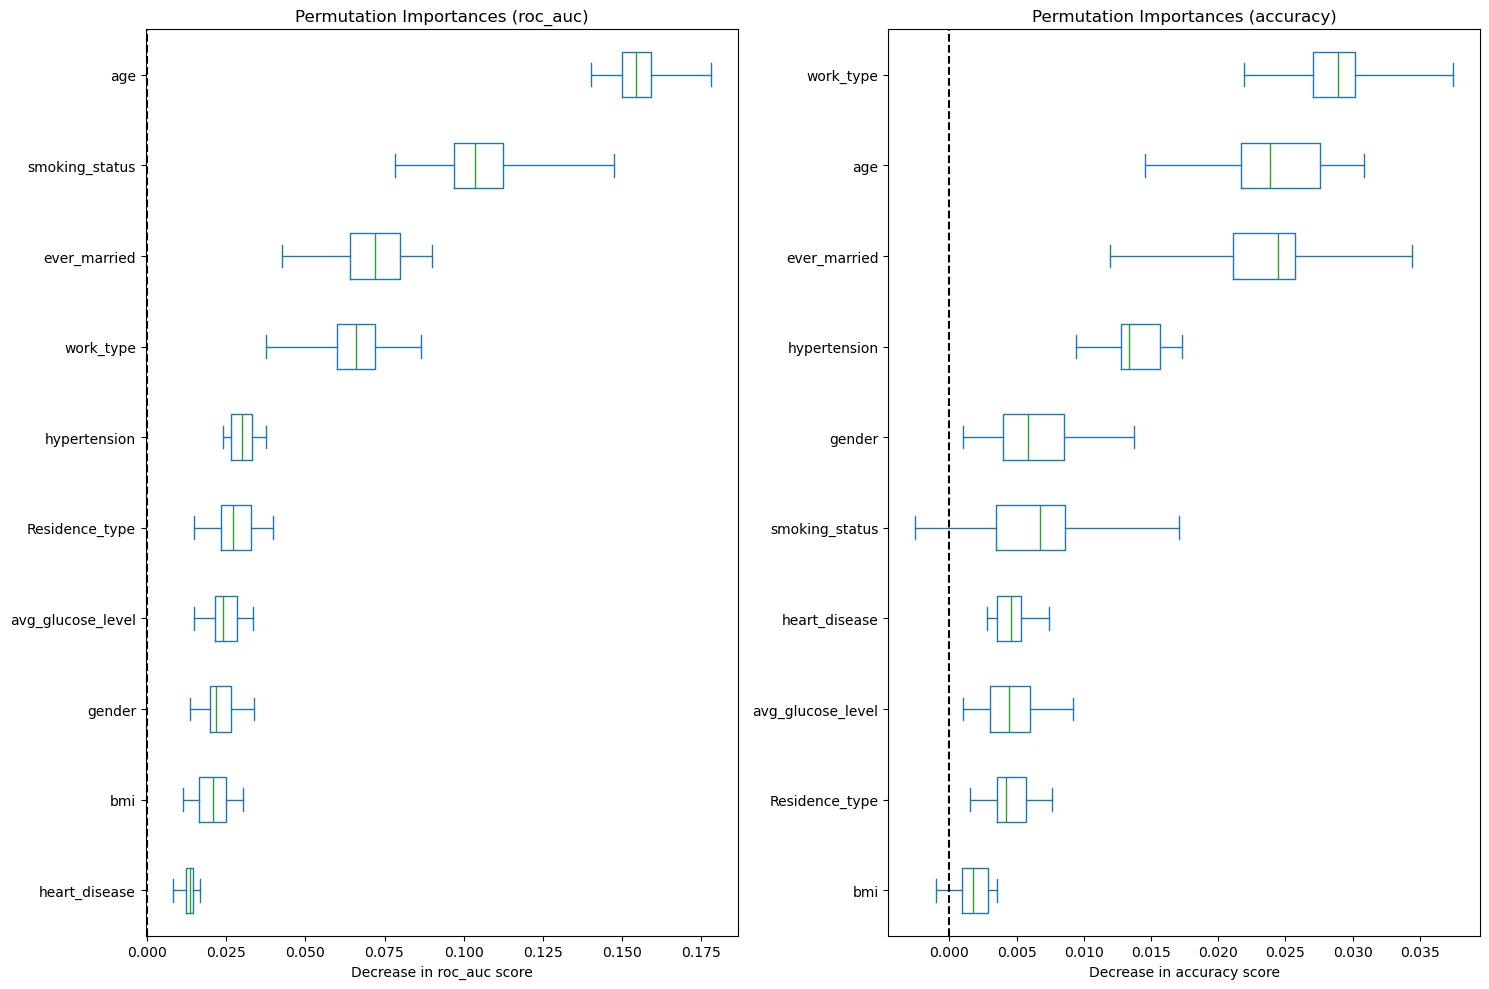

In [98]:
plot_permutation_feature_importance(
    dt_pipeline_tuned, X_train, y_train, metrics=["roc_auc", "accuracy"]
)

__<u>Test Metrics</u>__

In [99]:
dt_pipeline_tuned.fit(X_train, y_train)
dt_predictions = dt_pipeline_tuned.predict(X_test)
dt_model_assessment = model_assessment_series(
    y_test, dt_predictions, "final model test - Decision Tree"
)
pd.concat(
    [dt_model_assessment, kernel_svc_model_assessment, log_reg_model_assessment], axis=1
)

,final model test - Decision Tree,final model test - Kernel SVC,final model test - Logistic Regression
Accuracy,0.664628,0.689093,0.741081
Precision,0.088825,0.107463,0.124113
Recall,0.738095,0.857143,0.833333
F1-Score,0.158568,0.190981,0.216049
ROC-AUC (for class labels),0.699719,0.769360,0.785144


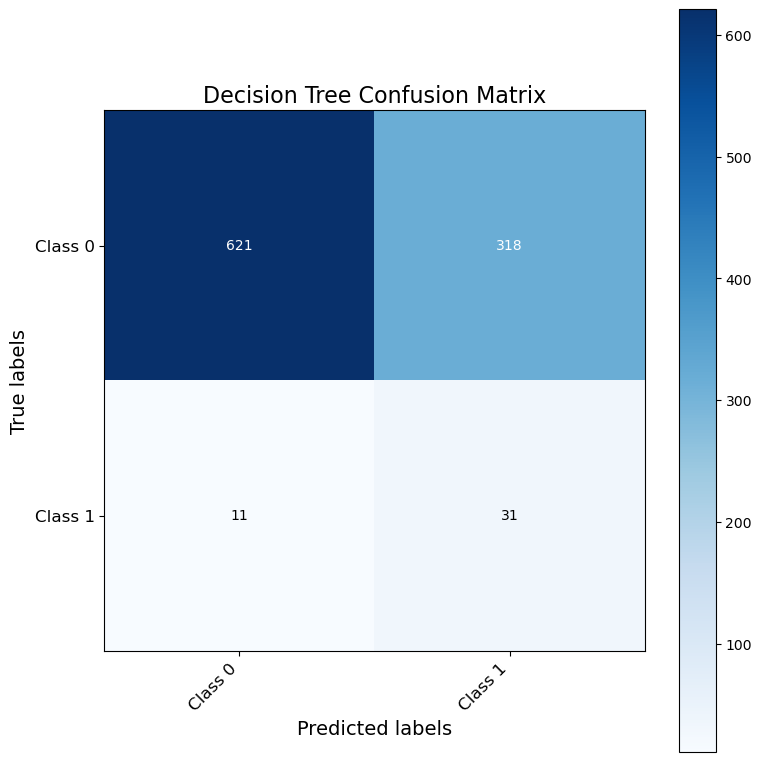

In [100]:
plot_confusion_matrix(
    y_test, dt_predictions, class_names, title="Decision Tree Confusion Matrix"
)

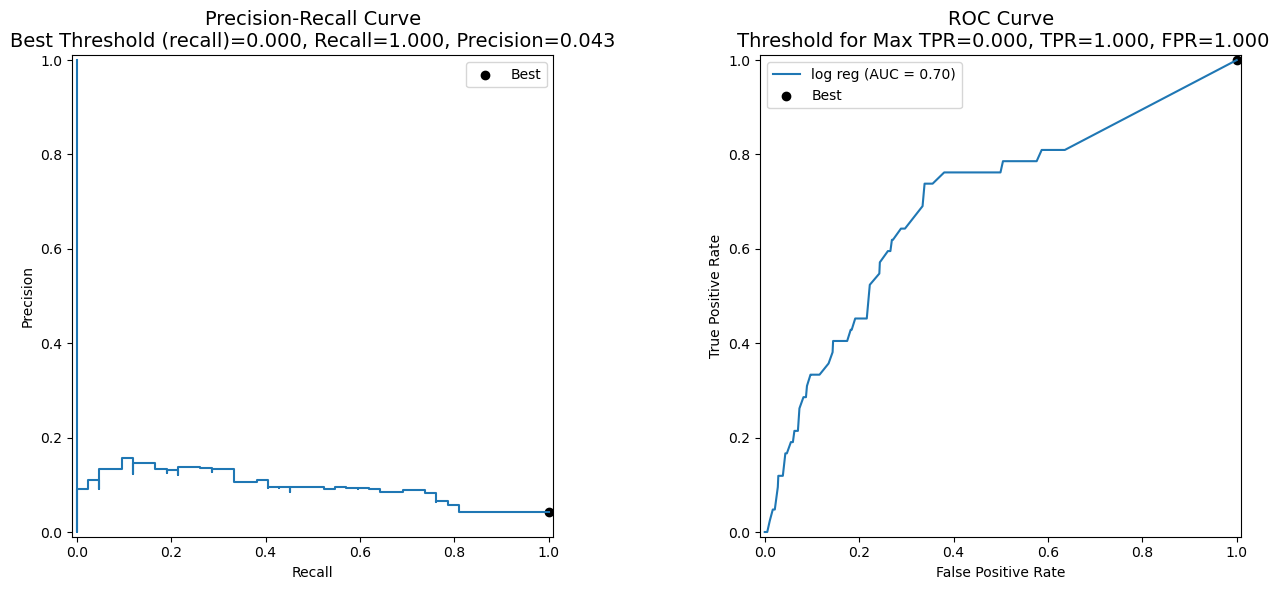

In [101]:
dt_probs = dt_pipeline_tuned.predict_proba(X_test)[:, 1]
plot_roc_pr_curves_with_best_threshold(y_test, dt_probs, metric="recall")

## Ensemble Models

## Random Forest 
__Baseline Model__

In [102]:
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced", classes=classes, y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)
rf_model = RandomForestClassifier(class_weight=class_weight_dict)
rf_pipeline = Pipeline(steps=[("preprocessor", preprocessing), ("model", rf_model)])
rf_pipeline.fit(X_train, y_train)
rf_baseline = model_assessment_series_cv(
    rf_pipeline, X_train, y_train, folds=5, model_name="random forest-baseline"
)
rf_baseline

{0: 0.5222310969116081, 1: 11.745508982035927}


Accuracy     0.956156
Precision    0.266667
Recall       0.011943
F1-Score     0.022576
ROC-AUC      0.759712
Name: random forest-baseline, dtype: float64

__Hyperparameter Tuning with GridSearchCV__

In [103]:
rf_model = RandomForestClassifier(class_weight={0: 1, 1: 20})
rf_pipeline = Pipeline(steps=[("preprocessor", preprocessing), ("model", rf_model)])
rf_pipeline.fit(X_train, y_train)
rf_ratio = model_assessment_series_cv(
    rf_pipeline, X_train, y_train, folds=5, model_name="random forest-new ratio"
)
pd.concat([rf_baseline, rf_ratio], axis=1)

,random forest-baseline,random forest-new ratio
Accuracy,0.956156,0.955646
Precision,0.266667,0.140000
Recall,0.011943,0.011943
F1-Score,0.022576,0.021685
ROC-AUC,0.759712,0.771005


In [104]:
rf_params = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__bootstrap": [True, False],
}

rf_gs = GridSearchCV(
    rf_pipeline, param_grid=rf_params, cv=5, scoring="roc_auc", n_jobs=-1
)
rf_gs.fit(X_train, y_train)
rf_best_params = rf_gs.best_params_
print(f"Best hyperparameters for Random Forest: {rf_best_params}")

Best hyperparameters for Random Forest: {'model__bootstrap': True, 'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 300}


In [105]:
rf_model_tuned = RandomForestClassifier(
    class_weight={0: 1, 1: 20},
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=4,
    max_depth=10,
    bootstrap=False,
)
rf_pipeline_tuned = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", rf_model_tuned)]
)
rf_pipeline_tuned.fit(X_train, y_train)
rf_tuned = model_assessment_series_cv(
    rf_pipeline, X_train, y_train, folds=5, model_name="random forest-tuned"
)
pd.concat([rf_baseline, rf_ratio, rf_tuned], axis=1)

,random forest-baseline,random forest-new ratio,random forest-tuned
Accuracy,0.956156,0.955646,0.956411
Precision,0.266667,0.140000,0.250000
Recall,0.011943,0.011943,0.011943
F1-Score,0.022576,0.021685,0.022291
ROC-AUC,0.759712,0.771005,0.770313


In [106]:
rf_params = {
    "model__n_estimators": [300, 400, 500],
    "model__max_depth": [30, 40, 50],
    "model__min_samples_leaf": [4, 8, 12],
}

rf_gs = GridSearchCV(
    rf_pipeline_tuned, param_grid=rf_params, cv=5, scoring="roc_auc", n_jobs=-1
)
rf_gs.fit(X_train, y_train)
rf_best_params = rf_gs.best_params_
print(f"Best hyperparameters for Random Forest: {rf_best_params}")

Best hyperparameters for Random Forest: {'model__max_depth': 30, 'model__min_samples_leaf': 12, 'model__n_estimators': 300}


In [107]:
rf_model_final = RandomForestClassifier(
    class_weight={0: 1, 1: 20},
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=4,
    max_depth=40,
    bootstrap=True,
)
rf_pipeline_final = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", rf_model_final)]
)
rf_pipeline_final.fit(X_train, y_train)
rf_final = model_assessment_series_cv(
    rf_pipeline_final, X_train, y_train, folds=5, model_name="random forest-final"
)
pd.concat([rf_baseline, rf_final, rf_ratio, rf_tuned], axis=1)

,random forest-baseline,random forest-final,random forest-new ratio,random forest-tuned
Accuracy,0.956156,0.933979,0.955646,0.956411
Precision,0.266667,0.160231,0.140000,0.250000
Recall,0.011943,0.138324,0.011943,0.011943
F1-Score,0.022576,0.147967,0.021685,0.022291
ROC-AUC,0.759712,0.809354,0.771005,0.770313


__Feature Importance__

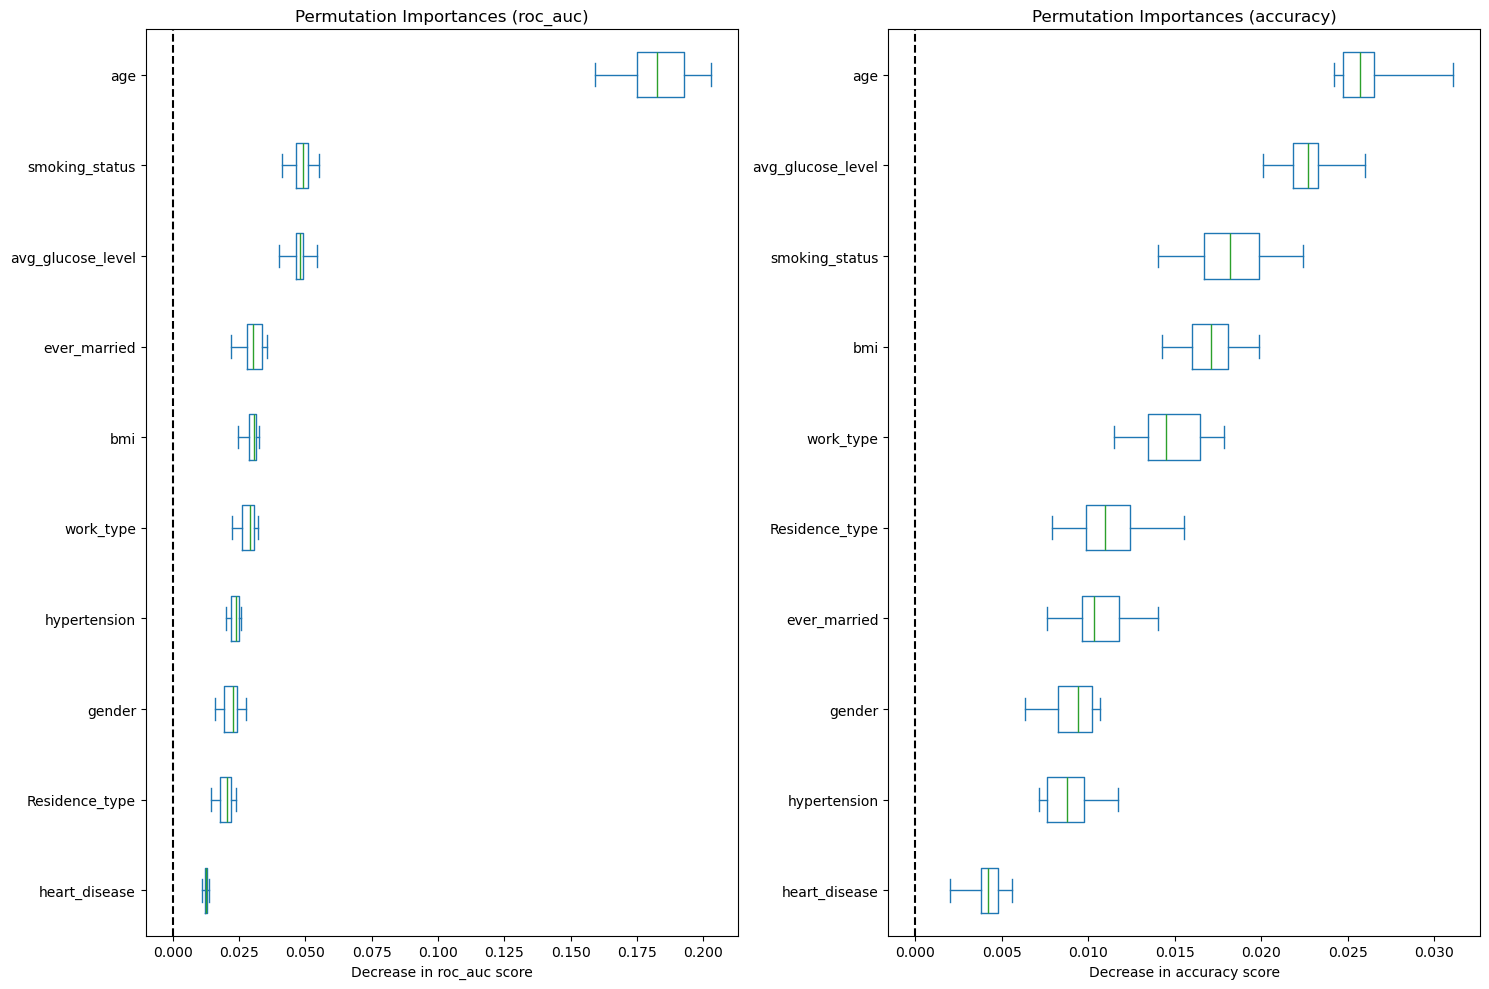

In [108]:
plot_permutation_feature_importance(
    rf_pipeline_final, X_train, y_train, metrics=["roc_auc", "accuracy"]
)

__<u>Test Metrics</u>__

In [109]:
rf_pipeline_final.fit(X_train, y_train)
rf_predictions = rf_pipeline_final.predict(X_test)
rf_model_assessment = model_assessment_series(
    y_test, rf_predictions, "final model test - Random Forest"
)
pd.concat(
    [
        rf_model_assessment,
        dt_model_assessment,
        kernel_svc_model_assessment,
        log_reg_model_assessment,
    ],
    axis=1,
)

,final model test - Random Forest,final model test - Decision Tree,final model test - Kernel SVC,final model test - Logistic Regression
Accuracy,0.940877,0.664628,0.689093,0.741081
Precision,0.233333,0.088825,0.107463,0.124113
Recall,0.166667,0.738095,0.857143,0.833333
F1-Score,0.194444,0.158568,0.190981,0.216049
ROC-AUC (for class labels),0.571086,0.699719,0.769360,0.785144


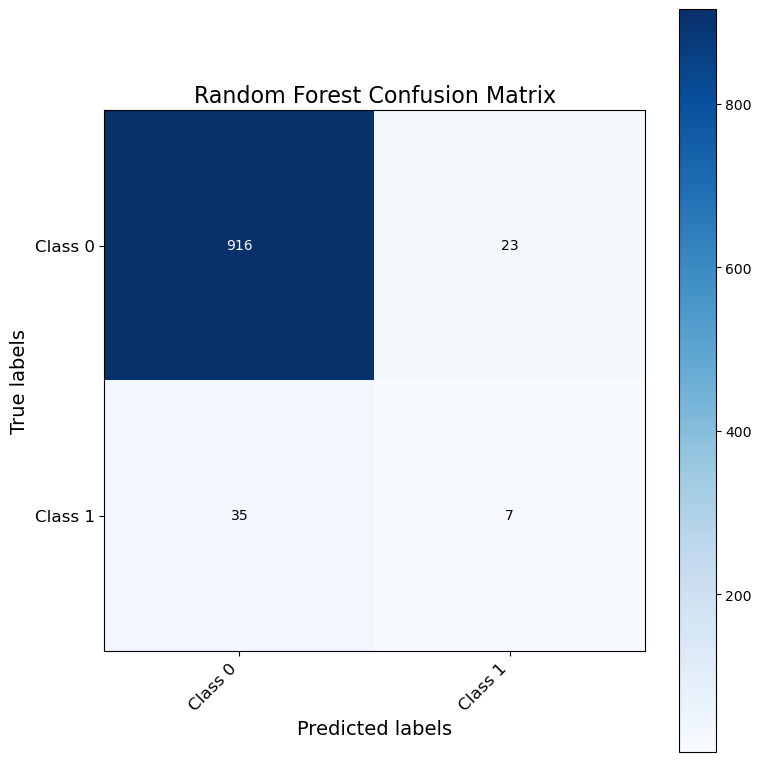

In [110]:
plot_confusion_matrix(
    y_test, rf_predictions, class_names, title="Random Forest Confusion Matrix"
)

In [111]:
rf_probs = rf_pipeline_final.predict_proba(X_test)[:, 1]

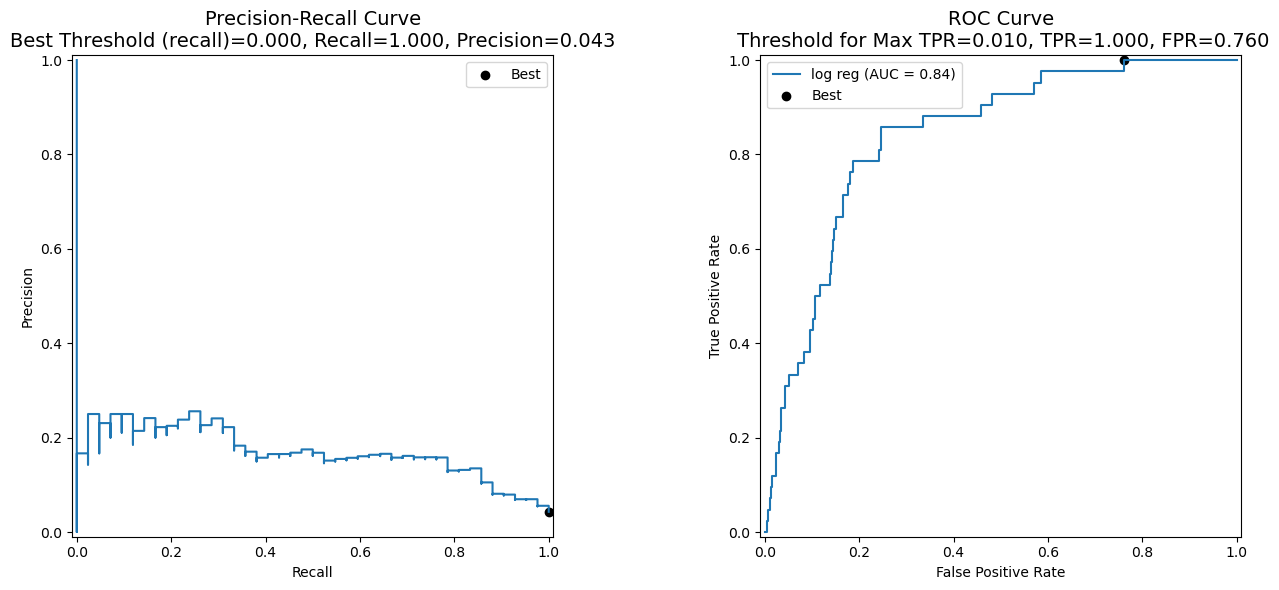

In [112]:
plot_roc_pr_curves_with_best_threshold(y_test, rf_probs, metric="recall")

### XGBoost

In [113]:
xgb_model = xgb.XGBClassifier(
    seed=0, nthread=1, n_jobs=-1, scale_pos_weight=class_weight_dict[1]
)
xgb_pipeline = Pipeline(steps=[("preprocessor", preprocessing), ("model", xgb_model)])
xgb_pipeline.fit(X_train, y_train)
xgb_baseline = model_assessment_series_cv(
    xgb_pipeline, X_train, y_train, model_name="xgboost - baseline"
)
xgb_baseline

Accuracy     0.935252
Precision    0.115507
Recall       0.083957
F1-Score     0.095360
ROC-AUC      0.781228
Name: xgboost - baseline, dtype: float64

__Hyperparameter Tuning with RandomizedSearchCV__

In [114]:
xgb_param_distributions = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__max_depth": [3, 6, 10],
    "model__min_child_weight": [1, 5, 10],
    "model__subsample": [0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.8, 0.9, 1.0],
}

xgb_rs = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

xgb_rs.fit(X_train, y_train)
xgb_best_params = xgb_rs.best_params_

print(f"Best hyperparameters for XGBoost: {xgb_best_params}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters for XGBoost: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__colsample_bytree': 1.0}


In [115]:
xgb_model_tuned = xgb.XGBClassifier(
    seed=0,
    nthread=1,
    n_jobs=-1,
    scale_pos_weight=class_weight_dict[1],
    subsample=0.9,
    n_estimators=100,
    min_child_weight=5,
    max_depth=3,
    learning_rate=0.01,
    colsample_bytree=0.9,
)
xgb_pipeline_tuned = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", xgb_model_tuned)]
)
xgb_pipeline_tuned.fit(X_train, y_train)
xgb_tuned = model_assessment_series_cv(
    xgb_pipeline_tuned, X_train, y_train, model_name="xgboost - tuned"
)
pd.concat([xgb_tuned, xgb_baseline], axis=1)

,xgboost - tuned,xgboost - baseline
Accuracy,0.884015,0.935252
Precision,0.159963,0.115507
Recall,0.419073,0.083957
F1-Score,0.230295,0.095360
ROC-AUC,0.831445,0.781228


In [116]:
xgb_param_distributions = {
    "model__n_estimators": stats.randint(50, 300),
    "model__learning_rate": stats.uniform(0.001, 0.1),
    "model__max_depth": stats.randint(3, 15),
    "model__min_child_weight": stats.randint(1, 10),
    "model__subsample": stats.uniform(0.1, 1.0),
    "model__colsample_bytree": stats.uniform(0.1, 1.0),
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    xgb_rs = RandomizedSearchCV(
        estimator=xgb_pipeline,
        param_distributions=xgb_param_distributions,
        n_iter=50,
        scoring="roc_auc",
        cv=3,
        n_jobs=-1,
        verbose=1,
    )

xgb_rs.fit(X_train, y_train)
xgb_best_params = xgb_rs.best_params_

print(f"Best hyperparameters for XGBoost: {xgb_best_params}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters for XGBoost: {'model__colsample_bytree': 0.6876074715630737, 'model__learning_rate': 0.011376343613959249, 'model__max_depth': 4, 'model__min_child_weight': 6, 'model__n_estimators': 209, 'model__subsample': 0.14712812231425057}


/Users/migueldiaz/anaconda3/envs/ds-mar24/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.81091345 0.81610116 0.80269283 0.82378057 0.82239032
        nan        nan 0.78985251 0.82249379 0.83259676 0.8236771
 0.80988176 0.80136448 0.830272   0.80003198 0.81285458 0.81392957
 0.75550375 0.81588688 0.79473068 0.8004074  0.80695199 0.83197646
 0.82434538 0.7972158  0.81999865 0.80507603        nan 0.81558882
 0.81691467        nan 0.79582867        nan 0.77912094 0.8292857
 0.81215181 0.80963316 0.78904912 0.79254526 0.8105631  0.82408086
 0.81612113 0.77923582 0.80995005 0.80703524 0.8035531  0.79769857
 0.81472008 0.77586995]
  warnings.warn(


In [117]:
xgb_model_tuned_2 = xgb.XGBClassifier(
    seed=0,
    nthread=1,
    n_jobs=-1,
    scale_pos_weight=class_weight_dict[1],
    subsample=0.65,
    n_estimators=90,
    min_child_weight=2,
    max_depth=1,
    learning_rate=0.05,
    colsample_bytree=0.47,
)
xgb_pipeline_tuned_2 = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", xgb_model_tuned_2)]
)
xgb_pipeline_tuned_2.fit(X_train, y_train)
xgb_tuned_2 = model_assessment_series_cv(
    xgb_pipeline_tuned_2, X_train, y_train, model_name="xgboost - tuned2"
)
pd.concat([xgb_tuned_2, xgb_tuned, xgb_baseline], axis=1)

,xgboost - tuned2,xgboost - tuned,xgboost - baseline
Accuracy,0.833293,0.884015,0.935252
Precision,0.148476,0.159963,0.115507
Recall,0.616399,0.419073,0.083957
F1-Score,0.238580,0.230295,0.095360
ROC-AUC,0.833364,0.831445,0.781228


In [118]:
xgb_model_final = xgb.XGBClassifier(
    seed=0,
    nthread=1,
    n_jobs=-1,
    scale_pos_weight=class_weight_dict[1],
    subsample=0.9,
    n_estimators=145,
    min_child_weight=1,
    max_depth=3,
    learning_rate=0.01,
    colsample_bytree=0.89,
)
xgb_pipeline_final = Pipeline(
    steps=[("preprocessor", preprocessing), ("model", xgb_model_final)]
)
xgb_pipeline_final.fit(X_train, y_train)
xgb_final = model_assessment_series_cv(
    xgb_pipeline_final, X_train, y_train, model_name="xgboost - final"
)
pd.concat([xgb_final, xgb_tuned_2, xgb_tuned, xgb_baseline], axis=1)

,xgboost - final,xgboost - tuned2,xgboost - tuned,xgboost - baseline
Accuracy,0.865407,0.833293,0.884015,0.935252
Precision,0.158178,0.148476,0.159963,0.115507
Recall,0.503387,0.616399,0.419073,0.083957
F1-Score,0.240187,0.238580,0.230295,0.095360
ROC-AUC,0.829233,0.833364,0.831445,0.781228


__Feature Importance__

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

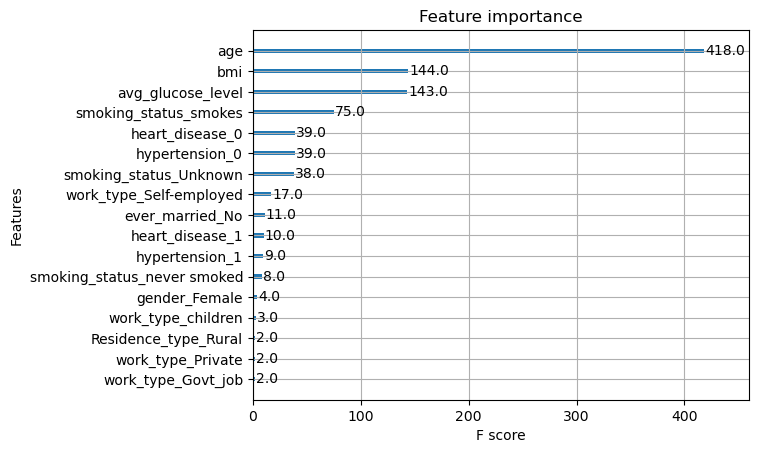

In [119]:
xgb.plot_importance(xgb_pipeline_final[-1])

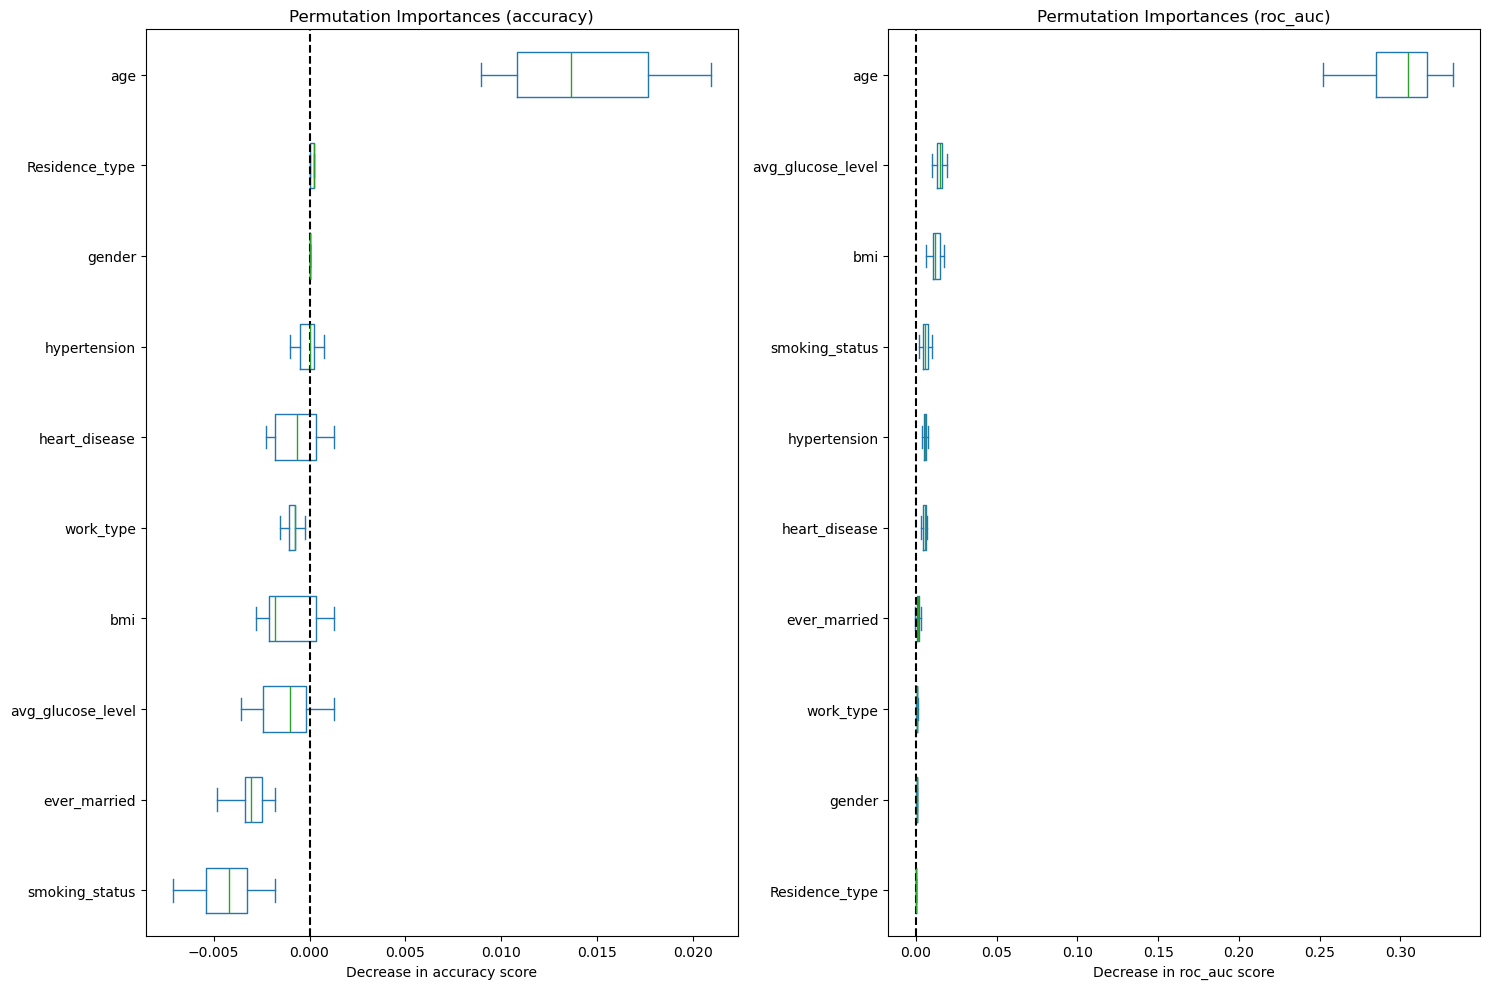

In [120]:
plot_permutation_feature_importance(
    xgb_pipeline_final, X_train, y_train, metrics=["accuracy", "roc_auc"]
)

__<u>Test Metrics</u>__

In [121]:
xgb_predictions = xgb_pipeline_final.predict(X_test)
xgb_model_assessment = model_assessment_series(
    y_test, xgb_predictions, "final model test - XGBoost"
)
pd.concat(
    [
        xgb_model_assessment,
        rf_model_assessment,
        dt_model_assessment,
        kernel_svc_model_assessment,
        log_reg_model_assessment,
    ],
    axis=1,
)

,final model test - XGBoost,final model test - Random Forest,final model test - Decision Tree,final model test - Kernel SVC,final model test - Logistic Regression
Accuracy,0.868502,0.940877,0.664628,0.689093,0.741081
Precision,0.172932,0.233333,0.088825,0.107463,0.124113
Recall,0.547619,0.166667,0.738095,0.857143,0.833333
F1-Score,0.262857,0.194444,0.158568,0.190981,0.216049
ROC-AUC (for class labels),0.715237,0.571086,0.699719,0.769360,0.785144


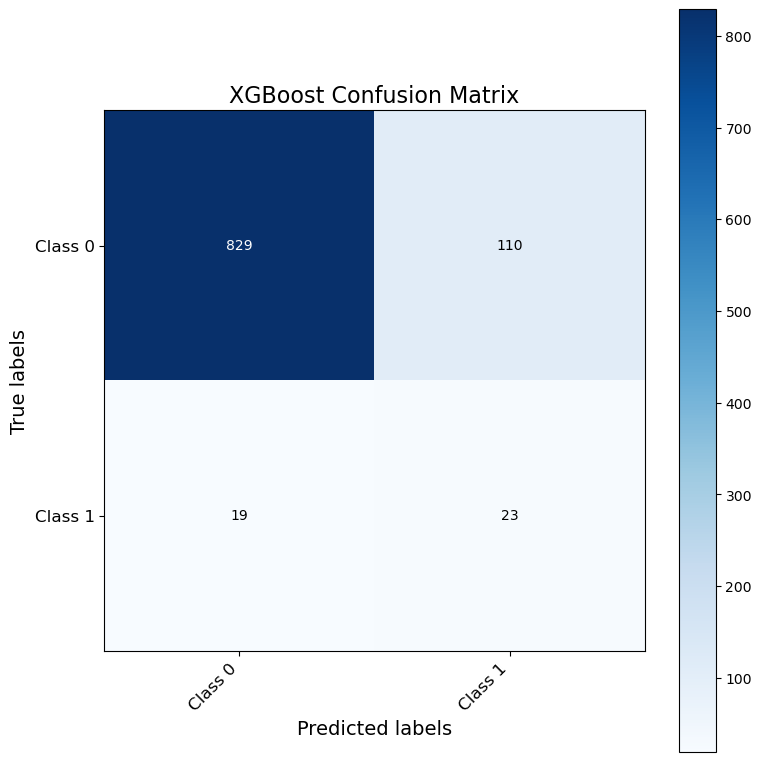

In [122]:
plot_confusion_matrix(
    y_test, xgb_predictions, class_names, title="XGBoost Confusion Matrix"
)

In [123]:
xgb_probs = xgb_pipeline_final.predict_proba(X_test)[:, 1]

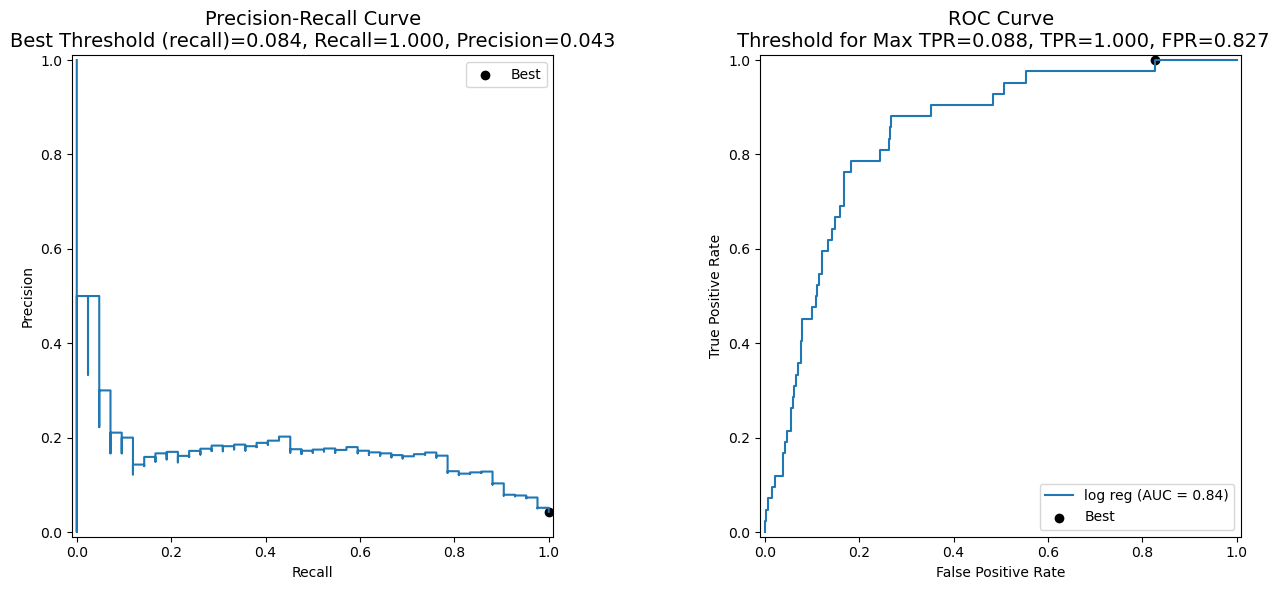

In [124]:
plot_roc_pr_curves_with_best_threshold(y_test, xgb_probs, metric="recall")

## Voting Models

In [125]:
pd.concat(
    [
        log_reg_final,
        poly_log_reg_final,
        linear_svc_tuned,
        kernel_svc_tuned,
        dt_tuned,
        rf_final,
        xgb_final,
    ],
    axis=1,
)

,logistic regression - final choice,polynomial logistic regression - final,linear svc - regularized,kernel svc - tuned,decision tree - tuned,random forest-final,xgboost - final
Accuracy,0.735660,0.690795,0.722915,0.671671,0.671399,0.933979,0.865407
Precision,0.115927,0.101974,0.110899,0.100117,0.087869,0.160231,0.158178
Recall,0.784135,0.802139,0.784314,0.837968,0.706952,0.138324,0.503387
F1-Score,0.201909,0.180848,0.194267,0.178810,0.155551,0.147967,0.240187
ROC-AUC,0.833858,0.830792,0.836536,0.837028,0.724373,0.809354,0.829233


### Hard Voting Model

In [126]:
hard_voting_model = VotingClassifier(
    estimators=[
        ("log_reg", log_reg_pipeline_final),
        ("poly_log_reg", poly_log_reg_pipeline_final),
        ("xgb", xgb_pipeline_final),
        ("linear_svc", linear_svc_pipeline_tuned),
        ("kernel_svc", kernel_svc_pipeline_tuned),
    ]
)

hard_voting_model.fit(X_train, y_train);

In [127]:
hard_voting_predictions = hard_voting_model.predict(X_test)
hard_voting_model_assessment = model_assessment_series(
    y_test, hard_voting_predictions, "final model test - Hard Voting Model"
)
pd.concat(
    [
        hard_voting_model_assessment,
        xgb_model_assessment,
        rf_model_assessment,
        dt_model_assessment,
        kernel_svc_model_assessment,
        poly_log_reg_model_assessment,
        log_reg_model_assessment,
    ],
    axis=1,
)

,final model test - Hard Voting Model,final model test - XGBoost,final model test - Random Forest,final model test - Decision Tree,final model test - Kernel SVC,final model test - Polynomial Logistic Regression,final model test - Logistic Regression
Accuracy,0.734964,0.868502,0.940877,0.664628,0.689093,0.709480,0.741081
Precision,0.121528,0.172932,0.233333,0.088825,0.107463,0.116719,0.124113
Recall,0.833333,0.547619,0.166667,0.738095,0.857143,0.880952,0.833333
F1-Score,0.212121,0.262857,0.194444,0.158568,0.190981,0.206128,0.216049
ROC-AUC (for class labels),0.781949,0.715237,0.571086,0.699719,0.769360,0.791381,0.785144


### Soft Voting Model

Support Vector Classifiers seem to do the best on this data, but they do not provide a probability estimate, so I will take the other weaker classifiers and place them to a soft vote in hopes to gain a somewhat confident probability from them. 

In [128]:
voting_model = VotingClassifier(
    estimators=[
        ("log_reg", log_reg_pipeline_final),
        ("poly_log_reg", poly_log_reg_pipeline_final),
        ("xgb", xgb_pipeline_final),
        ("dt", dt_pipeline_tuned),
        ("rf", rf_pipeline_tuned),
    ],
    voting="soft",
)

# Train the Voting Classifier
voting_model.fit(X_train, y_train)

model_assessment_series_cv(voting_model, X_train, y_train, model_name="voting_model")

Accuracy     0.795049
Precision    0.127008
Recall       0.652585
F1-Score     0.212354
ROC-AUC      0.826835
Name: voting_model, dtype: float64

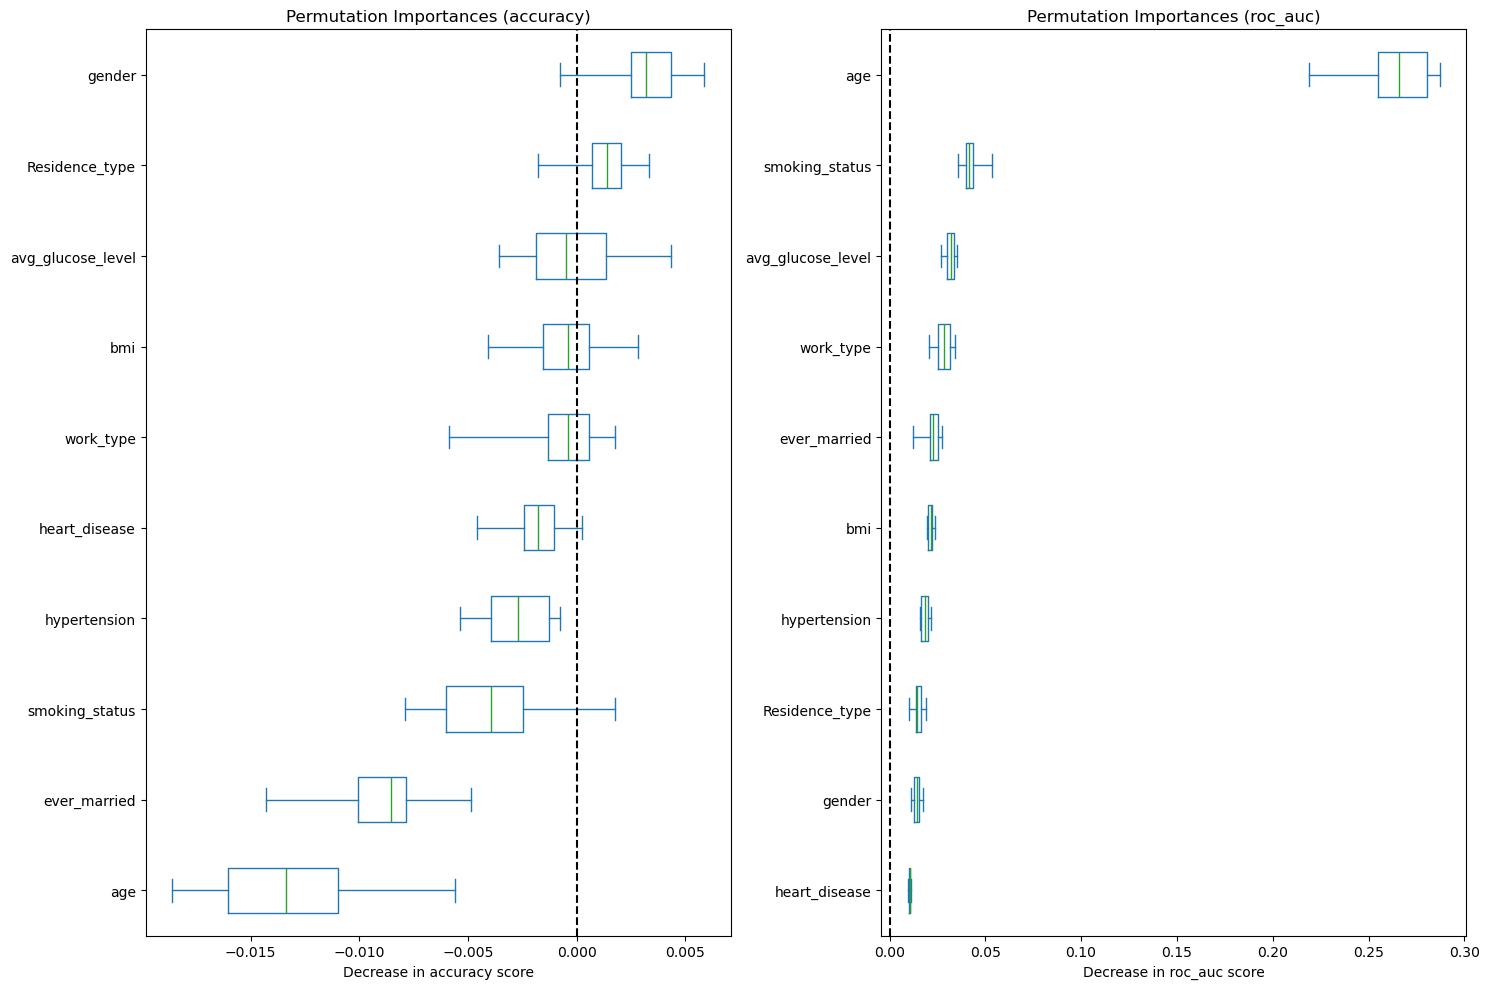

In [129]:
plot_permutation_feature_importance(
    voting_model, X_train, y_train, metrics=["accuracy", "roc_auc"]
)

In [130]:
voting_predictions = voting_model.predict(X_test)
voting_model_assessment = model_assessment_series(
    y_test, voting_predictions, "final model test - Voting Model"
)
pd.concat(
    [
        voting_model_assessment,
        hard_voting_model_assessment,
        xgb_model_assessment,
        rf_model_assessment,
        dt_model_assessment,
        kernel_svc_model_assessment,
        poly_log_reg_model_assessment,
        log_reg_model_assessment,
    ],
    axis=1,
)

,final model test - Voting Model,final model test - Hard Voting Model,final model test - XGBoost,final model test - Random Forest,final model test - Decision Tree,final model test - Kernel SVC,final model test - Polynomial Logistic Regression,final model test - Logistic Regression
Accuracy,0.811417,0.734964,0.868502,0.940877,0.664628,0.689093,0.709480,0.741081
Precision,0.151220,0.121528,0.172932,0.233333,0.088825,0.107463,0.116719,0.124113
Recall,0.738095,0.833333,0.547619,0.166667,0.738095,0.857143,0.880952,0.833333
F1-Score,0.251012,0.212121,0.262857,0.194444,0.158568,0.190981,0.206128,0.216049
ROC-AUC (for class labels),0.776396,0.781949,0.715237,0.571086,0.699719,0.769360,0.791381,0.785144


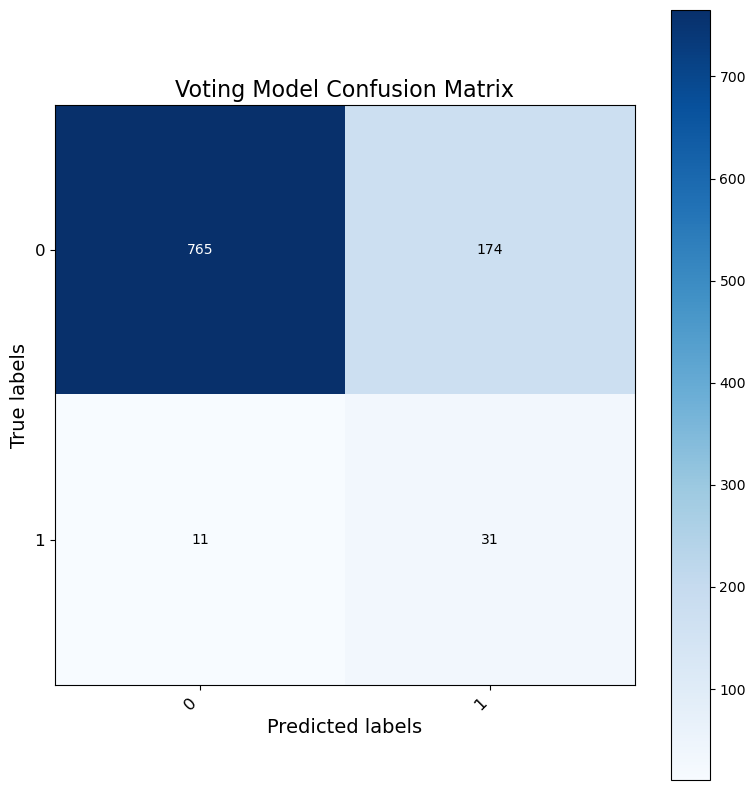

In [131]:
plot_confusion_matrix(
    y_test,
    voting_predictions,
    class_names=[0, 1],
    title="Voting Model Confusion Matrix",
)

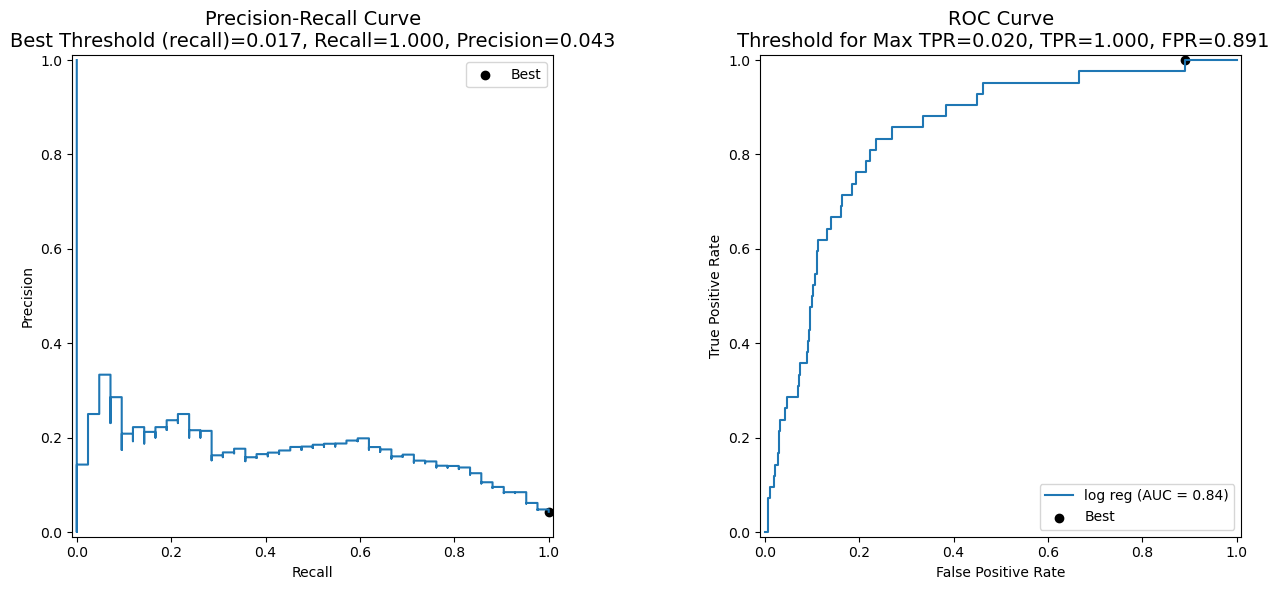

In [132]:
voting_model_probs = voting_model.predict_proba(X_test)[:, 1]
plot_roc_pr_curves_with_best_threshold(y_test, voting_model_probs, metric="recall")

In [133]:
pd.concat(
    [
        log_reg_model_assessment,
        poly_log_reg_model_assessment,
        linear_svc_model_assessment,
        kernel_svc_model_assessment,
        dt_model_assessment,
        rf_model_assessment,
        xgb_model_assessment,
        hard_voting_model_assessment,
        voting_model_assessment,
    ],
    axis=1,
)

,final model test - Logistic Regression,final model test - Polynomial Logistic Regression,final model test - Linear SVC,final model test - Kernel SVC,final model test - Decision Tree,final model test - Random Forest,final model test - XGBoost,final model test - Hard Voting Model,final model test - Voting Model
Accuracy,0.741081,0.709480,0.733945,0.689093,0.664628,0.940877,0.868502,0.734964,0.811417
Precision,0.124113,0.116719,0.121107,0.107463,0.088825,0.233333,0.172932,0.121528,0.151220
Recall,0.833333,0.880952,0.833333,0.857143,0.738095,0.166667,0.547619,0.833333,0.738095
F1-Score,0.216049,0.206128,0.211480,0.190981,0.158568,0.194444,0.262857,0.212121,0.251012
ROC-AUC (for class labels),0.785144,0.791381,0.781416,0.769360,0.699719,0.571086,0.715237,0.781949,0.776396


# Conclusions
In the end, I have chosen to deploy the polynomial logistic regression model because it displayed the highest test recall and for a diagnostic tool, I find this to be the most important factor that we can consider for our patients' long-term health. Moreover, in my EDA I have found a polynomial features (age*bmi^2) to be a visible trend. Lastly, the feature importance analysis for this model makes sense given what is known about factors influencing stroke ris. 

__Take Aways__
- Age is the most vital feature for stroke prediction
- People who have strokes have a significantly different BMI and average glucose level than people who do not
- Age likely interacts with other features. 
- Many models also find smoking status and hypertension to be predictive of stroke likelihood
- Simpler models outperform more complex models on this dataset. 

## Future Directions
- Explore more intricate feature engineering: especially features based on age 
- Consider efficacy and use cases for SVC classifiers given that they do not provide probabilities, but they do seem to perform relatively well across all classification metrics. 
- Consider adding imputation techniques into the pipeline for handling lack of input for end users of the application 
- Collect more data
- Improve boosting model parameters and try other boosting models
- Consider feature interpretability tools like SHAP and LIME for more in depth analysis of models

# Model Deployment
Serialize model for deployment<br>
See more model deployment details in _stroke_risk_deployment.py_

In [ ]:
os.makedirs('deployment', exist_ok=True)

In [134]:
import pickle

model = poly_log_reg_pipeline_final
model.fit(X_train, y_train)

with open("./deployment/model.pkl", "wb") as file:
    pickle.dump(model, file)